# Modeling

## Importing libraries

In [1]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
import numpy as np
from scipy import stats
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
import optuna
from optuna.samplers import TPESampler
import xgboost as xgb
from sklearn.metrics import r2_score, mean_absolute_error
import lightgbm as lgb
from catboost import CatBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import shap
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 100)

c:\anaconda\envs\finance\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Reading Data

In [2]:
df = pd.read_csv("nyc-rolling-sales.csv")

## Extract Basic Information From Data

In [3]:
# Basic Statistics (Numeric Variables)
df.describe()

,Unnamed: 0,BOROUGH,BLOCK,LOT,ZIP CODE,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,YEAR BUILT,TAX CLASS AT TIME OF SALE
count,84548.000000,84548.000000,84548.000000,84548.000000,84548.000000,84548.000000,84548.000000,84548.000000,84548.000000,84548.000000
mean,10344.359878,2.998758,4237.218976,376.224015,10731.991614,2.025264,0.193559,2.249184,1789.322976,1.657485
std,7151.779436,1.289790,3568.263407,658.136814,1290.879147,16.721037,8.713183,18.972584,537.344993,0.819341
min,4.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,4231.000000,2.000000,1322.750000,22.000000,10305.000000,0.000000,0.000000,1.000000,1920.000000,1.000000
50%,8942.000000,3.000000,3311.000000,50.000000,11209.000000,1.000000,0.000000,1.000000,1940.000000,2.000000
75%,15987.250000,4.000000,6281.000000,1001.000000,11357.000000,2.000000,0.000000,2.000000,1965.000000,2.000000
max,26739.000000,5.000000,16322.000000,9106.000000,11694.000000,1844.000000,2261.000000,2261.000000,2017.000000,4.000000


In [4]:
# Basic Statistics (Categorical Variables)
df.describe(include='object')

,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,EASE-MENT,BUILDING CLASS AT PRESENT,ADDRESS,APARTMENT NUMBER,LAND SQUARE FEET,GROSS SQUARE FEET,BUILDING CLASS AT TIME OF SALE,SALE PRICE,SALE DATE
count,84548,84548,84548,84548,84548,84548,84548,84548,84548,84548,84548,84548
unique,254,47,11,1,167,67563,3989,6062,5691,166,10008,364
top,FLUSHING-NORTH,01 ONE FAMILY DWELLINGS,1,,D4,131-05 40TH ROAD,,-,-,R4,-,2017-06-29 00:00:00
freq,3068,18235,38633,84548,12663,210,65496,26252,27612,12989,14561,544


## Feature Engineering

### Droping Unnecessary Columns

- Dropping the 'Unnamed: 0' column to clean up the DataFrame.
- The 'Unnamed: 0' column is usually created automatically during data import, especially when reading CSV files. 
- It often contains index values that are 
already present in the DataFrame's default index. 
- Removing this column eliminates redundancy and simplifies the dataset.

In [5]:
# Droping Unnamed: 0 column
df.drop(columns=['Unnamed: 0'], inplace=True)

### Converting Data Types

This function converts specific columns in a DataFrame to the correct data types.

- For numeric columns (like 'SALE PRICE', 'LAND SQUARE FEET', and 'GROSS SQUARE FEET'), it tries to convert them to numeric values. 
- If there are any invalid values that can't be converted, they will be set to NaN (Not a Number). Afterward, the column is converted to Int64 to handle any missing values appropriately.
- For the date column (e.g., 'SALE DATE'), the function converts it to a datetime format. If any invalid values are encountered, they will be set to NaT (Not a Time).

In [6]:
def convert_columns_type(df, numeric_columns, date_column):
    """
    Converts specified columns in a DataFrame to appropriate data types.

    For the numeric columns:
    - It attempts to convert the values to numeric types. If the conversion 
      fails (invalid values), these values will be set as NaN (Not a Number).
    - After that, NaN values are handled, and the column is converted to Int64 type.
    
    For the date column:
    - It converts the specified column to datetime format. If the conversion 
      fails, the invalid values will also be set as NaT (Not a Time).
    
    Args:
    df (pd.DataFrame): The DataFrame containing the columns to be converted.
    numeric_columns (list): List of numeric column names to be converted to Int64.
    date_column (str): The name of the column to be converted to datetime format.

    Returns:
    pd.DataFrame: The DataFrame with the specified columns converted to numeric and datetime types.
    """
    for column in numeric_columns:
        # Convert the column to numeric, invalid parsing will result in NaN, then convert to Int64
        df[column] = pd.to_numeric(df[column], errors='coerce').astype('Int64')
    df[date_column] = pd.to_datetime(df[date_column], errors='coerce')
    return df

# Example usage
columns_to_convert = ['SALE PRICE', 'LAND SQUARE FEET', 'GROSS SQUARE FEET']
df = convert_columns_type(df, columns_to_convert,'SALE DATE')

### Filling Missing Values

In [7]:
# Calculate percentage of missing values
missing = df.isnull().mean().sort_values(ascending=False) * 100
missing

GROSS SQUARE FEET                 32.658372
LAND SQUARE FEET                  31.049818
SALE PRICE                        17.222170
BOROUGH                            0.000000
RESIDENTIAL UNITS                  0.000000
BUILDING CLASS AT TIME OF SALE     0.000000
TAX CLASS AT TIME OF SALE          0.000000
YEAR BUILT                         0.000000
TOTAL UNITS                        0.000000
COMMERCIAL UNITS                   0.000000
ZIP CODE                           0.000000
NEIGHBORHOOD                       0.000000
APARTMENT NUMBER                   0.000000
ADDRESS                            0.000000
BUILDING CLASS AT PRESENT          0.000000
EASE-MENT                          0.000000
LOT                                0.000000
BLOCK                              0.000000
TAX CLASS AT PRESENT               0.000000
BUILDING CLASS CATEGORY            0.000000
SALE DATE                          0.000000
dtype: float64

- Converting the 'SALE PRICE', 'GROSS SQUARE FEET', and 'LAND SQUARE FEET' columns to float for numerical processing. 
- After converting, missing values in 'SALE PRICE' are filled based on the group average of 'BUILDING CLASS CATEGORY', 'BOROUGH', and 'NEIGHBORHOOD'.
- Similarly, missing values in 'GROSS SQUARE FEET' and 'LAND SQUARE FEET' are filled using the average from the groupings of 'BUILDING CLASS CATEGORY' and 'TAX CLASS AT TIME OF SALE'.
- After filling, the values are rounded and converted to 'Int64' type for consistency.

In [8]:
df['SALE PRICE'] = df['SALE PRICE'].astype(float)
df['GROSS SQUARE FEET'] = df['GROSS SQUARE FEET'].astype(float)
df['LAND SQUARE FEET'] = df['LAND SQUARE FEET'].astype(float)
df['SALE PRICE']= df.groupby(['BUILDING CLASS CATEGORY', 'BOROUGH', 'NEIGHBORHOOD'])['SALE PRICE'].transform(lambda x: x.fillna(x.mean()).round()).astype('Int64')
df['GROSS SQUARE FEET']= df.groupby(['BUILDING CLASS CATEGORY', 'TAX CLASS AT TIME OF SALE'])['GROSS SQUARE FEET'].transform(lambda x: x.fillna(x.mean()).round()).astype('Int64')
df['LAND SQUARE FEET']= df.groupby(['BUILDING CLASS CATEGORY', 'TAX CLASS AT TIME OF SALE'])['LAND SQUARE FEET'].transform(lambda x: x.fillna(x.mean()).round()).astype('Int64')

In [9]:
df.isna().sum()

BOROUGH                             0
NEIGHBORHOOD                        0
BUILDING CLASS CATEGORY             0
TAX CLASS AT PRESENT                0
BLOCK                               0
LOT                                 0
EASE-MENT                           0
BUILDING CLASS AT PRESENT           0
ADDRESS                             0
APARTMENT NUMBER                    0
ZIP CODE                            0
RESIDENTIAL UNITS                   0
COMMERCIAL UNITS                    0
TOTAL UNITS                         0
LAND SQUARE FEET                    0
GROSS SQUARE FEET                   0
YEAR BUILT                          0
TAX CLASS AT TIME OF SALE           0
BUILDING CLASS AT TIME OF SALE      0
SALE PRICE                        572
SALE DATE                           0
dtype: int64

### Removing Outliers

- This function removes outliers from the specified columns in the DataFrame using the Z-score method.
- The Z-score method identifies values that are a certain number of standard deviations away from the mean (defined by the threshold).
- Any data point with a Z-score greater than the specified threshold is considered an outlier and is removed.

In [10]:
def remove_outliers_zscore(df, columns, threshold=3):
    df_clean = df.copy()  # Make a copy of the original DataFrame
    df_clean.dropna(inplace=True)  # Drop any rows with missing values
    outlier_indices = set()  # Set to store indices of outliers
    
    for col in columns:
        z_scores = np.abs(stats.zscore(df_clean[col]))  # Calculate Z-scores for the column
        outliers = df_clean.index[z_scores > threshold]  # Get the indices of outliers where Z-score exceeds the threshold
        outlier_indices.update(outliers)  # Add outlier indices to the set
    
    # Remove all rows with outlier indices from the DataFrame
    df_clean = df_clean.drop(index=outlier_indices)
    
    return df_clean  # Return the cleaned DataFrame

# Get the list of numeric columns in the DataFrame
numeric_columns = df.select_dtypes(include=[np.number]).columns.tolist()

# Apply the outlier removal function to the numeric columns
df = remove_outliers_zscore(df, numeric_columns)

- Filter the DataFrame based on conditions for 'SALE PRICE', 'GROSS SQUARE FEET', and 'LAND SQUARE FEET'.
- The first line filters rows where the 'SALE PRICE' is between 100,000 and 5,000,000.
- The second line removes rows where 'GROSS SQUARE FEET' is greater than 10,000.
- The third line removes rows where 'LAND SQUARE FEET' is greater than 10,000.

- Filter the DataFrame to ensure consistency between 'TOTAL UNITS', 'RESIDENTIAL UNITS', and 'COMMERCIAL UNITS'.
- The first line ensures that 'TOTAL UNITS' equals the sum of 'RESIDENTIAL UNITS' and 'COMMERCIAL UNITS'.
- The second line removes any rows where 'TOTAL UNITS' is zero, as such values may be invalid or irrelevant.

In [11]:
df = df[df['TOTAL UNITS'] == df['RESIDENTIAL UNITS'] + df['COMMERCIAL UNITS']]
df = df[df['TOTAL UNITS'] != 0]

### Extracting Key Features from Sale Date (Year, Month, Day, Day of Week)

This code creates new features based on the 'SALE DATE' column, such as:

- 'year_sold': The year the property was sold.

- 'month_sold': The month the property was sold.

- 'day_sold': The exact day the property was sold.

- 'day_of_week_sold': The day of the week the property was sold (0 = Monday, 6 = Sunday).


In [12]:
# Extracting Key Features from Sale Date (Year, Month, Day, Day of Week)
df['SALE YEAR'] = df['SALE DATE'].dt.year
df['SALE MONTH'] = pd.to_datetime(df['SALE DATE'], errors='coerce').dt.month
df['SALE DAY'] = df['SALE DATE'].dt.day
df['SALE DAY OF WEEK'] = df['SALE DATE'].dt.dayofweek 
df['BUILDING AGE'] = df['SALE YEAR'] - df['YEAR BUILT']
df['BUILDING DENSITY'] = df['TOTAL UNITS'] / df['GROSS SQUARE FEET']

df['SEASON'] = df['SALE MONTH'].apply(lambda x: 'Winter' if x in [12, 1, 2] 
                                                          else 'Spring' if x in [3, 4, 5] 
                                                          else 'Summer' if x in [6, 7, 8] 
                                                          else 'Fall')
# Residential/Commercial Ratio
df['RESIDENTIAL COMMERCIAL RATIO'] = df['RESIDENTIAL UNITS'] / (df['COMMERCIAL UNITS'] + 1)
# New Building (Last 20 years)
df['NEW BUILDING'] = df['YEAR BUILT'].apply(lambda x: 1 if df['SALE YEAR'].max() - x <= 20 else 0)

### Scoring Numerical Columns Based on Quantile Ranges

This code assigns a score to each value in the specified numerical columns based on its quantile range.
The goal is to divide the values into four groups (1-4) based on their position within the 0-25%, 
25-50%, 50-75%, and 75-100% quantile ranges.

**Steps**:
1. Quantiles (0.25, 0.5, 0.75) are calculated for each numerical column.
2. A score is assigned based on which quantile range the value falls into:
    - 1 for 0-25% (low values)
    - 2 for 25-50%
    - 3 for 50-75%
    - 4 for 75-100% (high values)
 3. The score is stored in a new column (e.g., 'GROSS SQUARE FEET_SCORE'), with proper handling for missing values.
 4. The process is repeated for all specified numerical columns.

In [13]:
# List of numerical columns you want to apply this logic to
numerical_columns = ['GROSS SQUARE FEET', 'LAND SQUARE FEET']  # Add more numerical columns if needed

# Define a function to calculate quantiles and assign scores for numerical columns
def score_numerical_column(df, num_col):
    # Step 1: Calculate the quantiles for the numerical column
    quantiles = df[num_col].quantile([0.25, 0.5, 0.75])
    
    # Step 2: Define a function to assign the score based on the quantile ranges
    def assign_score(value):
        if pd.isna(value):  # Handle missing values
            return pd.NA
        elif value <= quantiles[0.25]:
            return 1  # 0-25% quantile
        elif value <= quantiles[0.5]:
            return 2  # 25-50% quantile
        elif value <= quantiles[0.75]:
            return 3  # 50-75% quantile
        else:
            return 4  # 75-100% quantile
    
    # Step 3: Apply the score assignment to the column
    score_column_name = f'{num_col}_SCORE'
    df[score_column_name] = df[num_col].apply(assign_score)
    df[score_column_name] = df[score_column_name].astype('Int64')  # Ensuring Int64 for handling missing values
    return df, score_column_name

# Apply the function to each numerical column
score_column_names = []
for col in numerical_columns:
    df, score_column_name = score_numerical_column(df, col)
    score_column_names.append(score_column_name)

# Display the first few rows of the updated DataFrame
df.head()

,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,EASE-MENT,BUILDING CLASS AT PRESENT,ADDRESS,APARTMENT NUMBER,ZIP CODE,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,SALE DATE,SALE YEAR,SALE MONTH,SALE DAY,SALE DAY OF WEEK,BUILDING AGE,BUILDING DENSITY,SEASON,RESIDENTIAL COMMERCIAL RATIO,NEW BUILDING,GROSS SQUARE FEET_SCORE,LAND SQUARE FEET_SCORE
0,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,392,6,,C2,153 AVENUE B,,10009,5,0,5,1633,6440,1900,2,C2,6625000,2017-07-19,2017,7,19,2,117,0.000776,Summer,5.0,0,4,2
1,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,399,26,,C7,234 EAST 4TH STREET,,10009,28,3,31,4616,18690,1900,2,C7,5438528,2016-12-14,2016,12,14,2,116,0.001659,Winter,7.0,0,4,4
2,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,399,39,,C7,197 EAST 3RD STREET,,10009,16,1,17,2212,7803,1900,2,C7,5438528,2016-12-09,2016,12,9,4,116,0.002179,Winter,8.0,0,4,3
3,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2B,402,21,,C4,154 EAST 7TH STREET,,10009,10,0,10,2272,6794,1913,2,C4,3936272,2016-09-23,2016,9,23,4,103,0.001472,Fall,10.0,0,4,3
4,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,404,55,,C2,301 EAST 10TH STREET,,10009,6,0,6,2369,4615,1900,2,C2,8000000,2016-11-17,2016,11,17,3,116,0.0013,Fall,6.0,0,4,3


### Grouping Columns by 'BUILDING CLASS AT TIME OF SALE' and Calculating the Average Sale Price
- This script performs a groupby operation on each column from the 'columns_to_group' list, 
along with the 'BUILDING CLASS AT TIME OF SALE' column, to calculate the mean 'SALE PRICE'.
- The resulting averages are stored in new columns (e.g., 'avg_price_by_NEIGHBORHOOD').
- Each new column is merged back into the original DataFrame.

In [14]:
columns_to_group = [
    'NEIGHBORHOOD', 
    'TAX CLASS AT PRESENT', 
    'ZIP CODE', 
    'SALE MONTH',
    'TOTAL UNITS',
    'RESIDENTIAL UNITS',
    'TAX CLASS AT TIME OF SALE',
    'BOROUGH',
    'SALE DAY',
    'LOT',
    'COMMERCIAL UNITS',
    'GROSS SQUARE FEET_SCORE',
    'LAND SQUARE FEET_SCORE'
]

# A groupby with 'BUILDING CLASS CATEGORY' for each column and calculate the averages
groupby_results = {}

for col in columns_to_group:
    grouped_df = df.groupby(['BUILDING CLASS AT TIME OF SALE', col])['SALE PRICE'].mean().reset_index()
    grouped_df.columns = ['BUILDING CLASS AT TIME OF SALE',col,f'avg_price_by_{col}']
    grouped_df[f'avg_price_by_{col}'] = grouped_df[f'avg_price_by_{col}'].astype('Int64')
    df = pd.merge(df, grouped_df, how='left', left_on=[col, 'BUILDING CLASS AT TIME OF SALE'], right_on=[col, 'BUILDING CLASS AT TIME OF SALE'])

### One-Hot Encoding for Numeric Columns
This code applies One-Hot Encoding to selected numeric columns (`BOROUGH`, `SALE DAY OF WEEK`, `SEASON`,
`NEW BUILDING`) to convert them into binary features for each unique category.

**Steps:**
1. Instantiate the OneHotEncoder and set `sparse_output=False` to return a dense array.
2. Fit and transform the selected numeric columns to create the encoded data.
3. Generate meaningful column names by combining the original column names with the unique categories.
4. Convert the encoded data into a DataFrame and assign the new column names.
5. Concatenate the original dataset with the new one-hot encoded columns.
6. Drop the original numeric columns to avoid redundancy, as the information is now represented by the encoded columns.

In [15]:
# Numeric columns where we will apply One-Hot Encoding
numeric_columns_for_ohe = ['BOROUGH','SALE DAY OF WEEK','SEASON','NEW BUILDING']

# Instantiate OneHotEncoder
encoder = OneHotEncoder(sparse_output=False, drop='first')

# Fit and transform the selected numeric columns
encoded_data = encoder.fit_transform(df[numeric_columns_for_ohe])

# Convert the encoded array into a DataFrame with proper column names
# Generate more meaningful column names
encoded_column_names = []
for original_col, categories in zip(numeric_columns_for_ohe, encoder.categories_):
    for category in categories[1:]:  # Skipping the first category due to drop='first'
        encoded_column_names.append(f'{original_col}_{category}')

# Create DataFrame with the encoded columns and new names
encoded_df = pd.DataFrame(encoded_data, columns=encoded_column_names)

# Concatenate the new One-Hot Encoded columns with the original dataset
data = pd.concat([df.reset_index(drop=True), encoded_df.astype('Int64')], axis=1)

# (Optional): Drop the original numeric columns
data.drop(numeric_columns_for_ohe, axis=1, inplace=True)

### Creating Features and Target Value

In [16]:
data.drop(columns = ['NEIGHBORHOOD', 'BUILDING CLASS CATEGORY',
       'TAX CLASS AT PRESENT', 'EASE-MENT',
       'BUILDING CLASS AT PRESENT', 'ADDRESS', 'APARTMENT NUMBER', 'ZIP CODE','YEAR BUILT',
       'TAX CLASS AT TIME OF SALE', 'BUILDING CLASS AT TIME OF SALE','SALE DATE', 'SALE YEAR', 'SALE MONTH', 'SALE DAY'], inplace= True)

In [17]:
X = data.drop(columns= ['SALE PRICE']).astype(int)
y = data['SALE PRICE']  

### Correlation Matrix

<Figure size 5000x600 with 0 Axes>

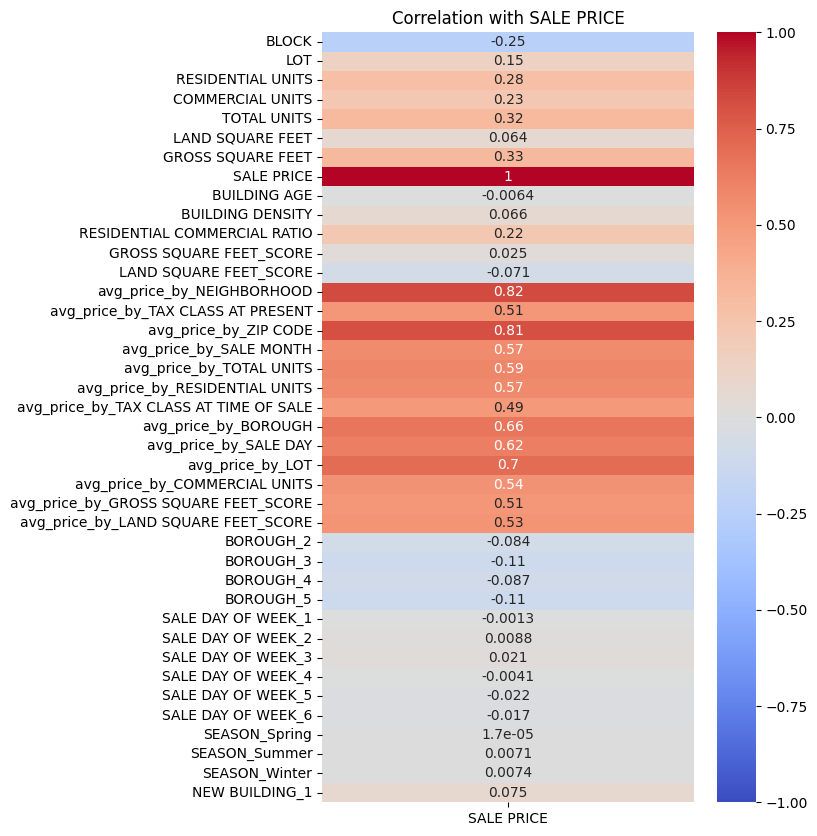

In [18]:
# Correlation Matrix (Among Numeric Variables)
plt.figure(figsize=(50, 6))
correlation = data.corr()
# Filter to show only the correlation with 'SALE PRICE'
sale_price_correlation = correlation[['SALE PRICE']]

# Plot the heatmap
plt.figure(figsize=(6, 10))
sns.heatmap(sale_price_correlation, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation with SALE PRICE')
plt.show()

## Modeling

### Extract Model Summary

### Creating a Linear Regression Model and Viewing the Model Summary
- This code splits the data into training and test sets, builds a linear regression model, and displays
the summary of the trained model. The goal is to evaluate the model's performance and analyze the
impact of each independent variable on the target variable (`SALE PRICE`).

In [19]:
# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to NumPy format
X_train_np = np.asarray(X_train, dtype=np.float64)
y_train_np = np.asarray(y_train, dtype=np.float64)

# Adding a constant term to the features and updating column names
X_train_with_constant = sm.add_constant(X_train_np)
column_names_with_constant = ['const'] + X_train.columns.tolist()

# Building the linear regression model
linear_model = sm.OLS(y_train_np, X_train_with_constant)
linear_model_fitted = linear_model.fit()

# Displaying the model summary
print(linear_model_fitted.summary(xname=column_names_with_constant))

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.710
Model:                            OLS   Adj. R-squared:                  0.710
Method:                 Least Squares   F-statistic:                     2908.
Date:                Mon, 16 Sep 2024   Prob (F-statistic):               0.00
Time:                        18:00:22   Log-Likelihood:            -6.9768e+05
No. Observations:               45220   AIC:                         1.395e+06
Df Residuals:                   45181   BIC:                         1.396e+06
Df Model:                          38                                         
Covariance Type:            nonrobust                                         
                                             coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------

### Creating Train Test

In [20]:
# Create feature matrix `X` and target variable `y`
X = data.drop(columns= ['SALE PRICE','GROSS SQUARE FEET_SCORE','avg_price_by_TAX CLASS AT PRESENT','avg_price_by_RESIDENTIAL UNITS','avg_price_by_COMMERCIAL UNITS',
'SALE DAY OF WEEK_1','SALE DAY OF WEEK_2','SALE DAY OF WEEK_3','SALE DAY OF WEEK_4','SALE DAY OF WEEK_5','SALE DAY OF WEEK_6', 'BLOCK']).astype(int)
# Set target variable
y = data['SALE PRICE']  
# Split the data into training (70%) and test sets (30%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### Finding Best Parameters

In [584]:
# Hyperparameter tuning with Optuna for LightGBM
def objective_lightgbm(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'num_leaves': trial.suggest_int('num_leaves', 20, 300),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-4, 1e1),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-4, 1e1)
    }
    
    model = lgb.LGBMRegressor(**param, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return mean_squared_error(y_test, y_pred)

study_lightgbm = optuna.create_study(direction='minimize', sampler=TPESampler())
study_lightgbm.optimize(objective_lightgbm, n_trials=100)

[I 2024-09-15 18:19:48,993] A new study created in memory with name: no-name-644ed3ef-c612-47c3-b8b2-9ff5bb04287b
C:\Users\Mehmet Buğra Kara\AppData\Local\Temp\ipykernel_6000\4131106257.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
C:\Users\Mehmet Buğra Kara\AppData\Local\Temp\ipykernel_6000\4131106257.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
C:\Users\Mehmet Buğra Kara\AppData\Local\Temp\ipykernel_6000\4131106257.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001288 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3552
[LightGBM] [Info] Number of data points in the train set: 39567, number of used features: 29
[LightGBM] [Info] Start training from score 1138821.143251


[I 2024-09-15 18:19:52,235] Trial 0 finished with value: 1263706390530.8242 and parameters: {'n_estimators': 565, 'num_leaves': 258, 'learning_rate': 0.0162681170042475, 'subsample': 0.6044721985688034, 'colsample_bytree': 0.8679533496510694, 'reg_alpha': 0.005901721642063172, 'reg_lambda': 0.015070603522135434}. Best is trial 0 with value: 1263706390530.8242.
C:\Users\Mehmet Buğra Kara\AppData\Local\Temp\ipykernel_6000\4131106257.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
C:\Users\Mehmet Buğra Kara\AppData\Local\Temp\ipykernel_6000\4131106257.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': 

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000944 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3552
[LightGBM] [Info] Number of data points in the train set: 39567, number of used features: 29
[LightGBM] [Info] Start training from score 1138821.143251


[I 2024-09-15 18:19:53,200] Trial 1 finished with value: 4216645750463.5635 and parameters: {'n_estimators': 318, 'num_leaves': 118, 'learning_rate': 0.0003329528255882881, 'subsample': 0.7727531450317207, 'colsample_bytree': 0.7068672855088727, 'reg_alpha': 0.014939582288970977, 'reg_lambda': 0.01552058927013524}. Best is trial 0 with value: 1263706390530.8242.
C:\Users\Mehmet Buğra Kara\AppData\Local\Temp\ipykernel_6000\4131106257.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
C:\Users\Mehmet Buğra Kara\AppData\Local\Temp\ipykernel_6000\4131106257.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample'

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001521 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3552
[LightGBM] [Info] Number of data points in the train set: 39567, number of used features: 29
[LightGBM] [Info] Start training from score 1138821.143251


[I 2024-09-15 18:19:53,636] Trial 2 finished with value: 3460175307977.503 and parameters: {'n_estimators': 313, 'num_leaves': 46, 'learning_rate': 0.0008407285481045141, 'subsample': 0.6099999301046265, 'colsample_bytree': 0.6035449205865651, 'reg_alpha': 0.06847748017652176, 'reg_lambda': 0.00904626822364903}. Best is trial 0 with value: 1263706390530.8242.
C:\Users\Mehmet Buğra Kara\AppData\Local\Temp\ipykernel_6000\4131106257.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
C:\Users\Mehmet Buğra Kara\AppData\Local\Temp\ipykernel_6000\4131106257.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': t

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001120 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3552
[LightGBM] [Info] Number of data points in the train set: 39567, number of used features: 29
[LightGBM] [Info] Start training from score 1138821.143251


[I 2024-09-15 18:19:58,335] Trial 3 finished with value: 4338063622242.026 and parameters: {'n_estimators': 781, 'num_leaves': 264, 'learning_rate': 0.00011111756707918279, 'subsample': 0.8809523894763167, 'colsample_bytree': 0.6115458595537604, 'reg_alpha': 0.030382436865786577, 'reg_lambda': 0.0876957511796986}. Best is trial 0 with value: 1263706390530.8242.
C:\Users\Mehmet Buğra Kara\AppData\Local\Temp\ipykernel_6000\4131106257.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
C:\Users\Mehmet Buğra Kara\AppData\Local\Temp\ipykernel_6000\4131106257.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample':

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001656 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3552
[LightGBM] [Info] Number of data points in the train set: 39567, number of used features: 29
[LightGBM] [Info] Start training from score 1138821.143251


[I 2024-09-15 18:19:59,633] Trial 4 finished with value: 4376923191628.982 and parameters: {'n_estimators': 463, 'num_leaves': 125, 'learning_rate': 0.000167896294333823, 'subsample': 0.9497172015082426, 'colsample_bytree': 0.9323883877087744, 'reg_alpha': 5.134474287120847, 'reg_lambda': 0.0014978135052770359}. Best is trial 0 with value: 1263706390530.8242.
C:\Users\Mehmet Buğra Kara\AppData\Local\Temp\ipykernel_6000\4131106257.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
C:\Users\Mehmet Buğra Kara\AppData\Local\Temp\ipykernel_6000\4131106257.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': t

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000779 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3552
[LightGBM] [Info] Number of data points in the train set: 39567, number of used features: 29
[LightGBM] [Info] Start training from score 1138821.143251


[I 2024-09-15 18:20:01,447] Trial 5 finished with value: 1167402494034.1016 and parameters: {'n_estimators': 491, 'num_leaves': 170, 'learning_rate': 0.012667027208586383, 'subsample': 0.9434075364764697, 'colsample_bytree': 0.510827422974931, 'reg_alpha': 0.004672398721984195, 'reg_lambda': 3.1507607539500166}. Best is trial 5 with value: 1167402494034.1016.
C:\Users\Mehmet Buğra Kara\AppData\Local\Temp\ipykernel_6000\4131106257.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
C:\Users\Mehmet Buğra Kara\AppData\Local\Temp\ipykernel_6000\4131106257.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': t

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001767 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3552
[LightGBM] [Info] Number of data points in the train set: 39567, number of used features: 29
[LightGBM] [Info] Start training from score 1138821.143251


[I 2024-09-15 18:20:04,228] Trial 6 finished with value: 1358615691554.7397 and parameters: {'n_estimators': 907, 'num_leaves': 180, 'learning_rate': 0.09336430665238557, 'subsample': 0.9275131626776996, 'colsample_bytree': 0.692985411563336, 'reg_alpha': 0.057799639247349245, 'reg_lambda': 0.001040496844297151}. Best is trial 5 with value: 1167402494034.1016.
C:\Users\Mehmet Buğra Kara\AppData\Local\Temp\ipykernel_6000\4131106257.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
C:\Users\Mehmet Buğra Kara\AppData\Local\Temp\ipykernel_6000\4131106257.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': 

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001384 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3552
[LightGBM] [Info] Number of data points in the train set: 39567, number of used features: 29
[LightGBM] [Info] Start training from score 1138821.143251


[I 2024-09-15 18:20:07,180] Trial 7 finished with value: 3405254856784.4478 and parameters: {'n_estimators': 988, 'num_leaves': 156, 'learning_rate': 0.00027924035655466014, 'subsample': 0.9176787558797987, 'colsample_bytree': 0.5238446318036577, 'reg_alpha': 0.002323785616855029, 'reg_lambda': 0.036807451256872674}. Best is trial 5 with value: 1167402494034.1016.
C:\Users\Mehmet Buğra Kara\AppData\Local\Temp\ipykernel_6000\4131106257.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
C:\Users\Mehmet Buğra Kara\AppData\Local\Temp\ipykernel_6000\4131106257.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsampl

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001645 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3552
[LightGBM] [Info] Number of data points in the train set: 39567, number of used features: 29
[LightGBM] [Info] Start training from score 1138821.143251


[I 2024-09-15 18:20:08,631] Trial 8 finished with value: 1229300715785.7307 and parameters: {'n_estimators': 967, 'num_leaves': 66, 'learning_rate': 0.025399189907044883, 'subsample': 0.9643412050258164, 'colsample_bytree': 0.5918628784042728, 'reg_alpha': 0.9921476011181338, 'reg_lambda': 0.0043097116884560195}. Best is trial 5 with value: 1167402494034.1016.
C:\Users\Mehmet Buğra Kara\AppData\Local\Temp\ipykernel_6000\4131106257.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
C:\Users\Mehmet Buğra Kara\AppData\Local\Temp\ipykernel_6000\4131106257.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': 

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001646 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3552
[LightGBM] [Info] Number of data points in the train set: 39567, number of used features: 29
[LightGBM] [Info] Start training from score 1138821.143251


[I 2024-09-15 18:20:10,686] Trial 9 finished with value: 1375828901972.1753 and parameters: {'n_estimators': 628, 'num_leaves': 172, 'learning_rate': 0.08744845445915933, 'subsample': 0.7544833207838286, 'colsample_bytree': 0.8311445760187253, 'reg_alpha': 3.5400453368745746, 'reg_lambda': 2.022550028652132}. Best is trial 5 with value: 1167402494034.1016.
C:\Users\Mehmet Buğra Kara\AppData\Local\Temp\ipykernel_6000\4131106257.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
C:\Users\Mehmet Buğra Kara\AppData\Local\Temp\ipykernel_6000\4131106257.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': tria

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001508 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3552
[LightGBM] [Info] Number of data points in the train set: 39567, number of used features: 29
[LightGBM] [Info] Start training from score 1138821.143251


[I 2024-09-15 18:20:11,443] Trial 10 finished with value: 2129749434195.6357 and parameters: {'n_estimators': 202, 'num_leaves': 208, 'learning_rate': 0.004087176984173274, 'subsample': 0.8167568646306975, 'colsample_bytree': 0.522688771859114, 'reg_alpha': 0.0002060352015268293, 'reg_lambda': 9.341035599484208}. Best is trial 5 with value: 1167402494034.1016.
C:\Users\Mehmet Buğra Kara\AppData\Local\Temp\ipykernel_6000\4131106257.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
C:\Users\Mehmet Buğra Kara\AppData\Local\Temp\ipykernel_6000\4131106257.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': 

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001677 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3552
[LightGBM] [Info] Number of data points in the train set: 39567, number of used features: 29
[LightGBM] [Info] Start training from score 1138821.143251


[I 2024-09-15 18:20:12,131] Trial 11 finished with value: 1208310134458.6033 and parameters: {'n_estimators': 728, 'num_leaves': 25, 'learning_rate': 0.014244347788520167, 'subsample': 0.967517139003834, 'colsample_bytree': 0.6066633345016208, 'reg_alpha': 0.4800732934962258, 'reg_lambda': 0.00015123335882315152}. Best is trial 5 with value: 1167402494034.1016.
C:\Users\Mehmet Buğra Kara\AppData\Local\Temp\ipykernel_6000\4131106257.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
C:\Users\Mehmet Buğra Kara\AppData\Local\Temp\ipykernel_6000\4131106257.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample':

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001322 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3552
[LightGBM] [Info] Number of data points in the train set: 39567, number of used features: 29
[LightGBM] [Info] Start training from score 1138821.143251


[I 2024-09-15 18:20:13,459] Trial 12 finished with value: 1161728436435.9006 and parameters: {'n_estimators': 721, 'num_leaves': 89, 'learning_rate': 0.005233258998277105, 'subsample': 0.8472246818735204, 'colsample_bytree': 0.5045999414535753, 'reg_alpha': 0.3628422978492791, 'reg_lambda': 0.00013622643508766715}. Best is trial 12 with value: 1161728436435.9006.
C:\Users\Mehmet Buğra Kara\AppData\Local\Temp\ipykernel_6000\4131106257.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
C:\Users\Mehmet Buğra Kara\AppData\Local\Temp\ipykernel_6000\4131106257.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002500 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3552
[LightGBM] [Info] Number of data points in the train set: 39567, number of used features: 29
[LightGBM] [Info] Start training from score 1138821.143251


[I 2024-09-15 18:20:14,401] Trial 13 finished with value: 1424449352214.8728 and parameters: {'n_estimators': 447, 'num_leaves': 95, 'learning_rate': 0.003257349434622559, 'subsample': 0.851167178055633, 'colsample_bytree': 0.5036638711804716, 'reg_alpha': 0.0010134877865208124, 'reg_lambda': 0.26636918414092625}. Best is trial 12 with value: 1161728436435.9006.
C:\Users\Mehmet Buğra Kara\AppData\Local\Temp\ipykernel_6000\4131106257.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
C:\Users\Mehmet Buğra Kara\AppData\Local\Temp\ipykernel_6000\4131106257.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample'

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001474 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3552
[LightGBM] [Info] Number of data points in the train set: 39567, number of used features: 29
[LightGBM] [Info] Start training from score 1138821.143251


[I 2024-09-15 18:20:17,311] Trial 14 finished with value: 1187247532746.5166 and parameters: {'n_estimators': 722, 'num_leaves': 211, 'learning_rate': 0.006694815572383193, 'subsample': 0.6678423846969164, 'colsample_bytree': 0.7637071113000282, 'reg_alpha': 0.21887793812362907, 'reg_lambda': 0.00010329544014515525}. Best is trial 12 with value: 1161728436435.9006.
C:\Users\Mehmet Buğra Kara\AppData\Local\Temp\ipykernel_6000\4131106257.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
C:\Users\Mehmet Buğra Kara\AppData\Local\Temp\ipykernel_6000\4131106257.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsamp

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001545 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3552
[LightGBM] [Info] Number of data points in the train set: 39567, number of used features: 29
[LightGBM] [Info] Start training from score 1138821.143251


[I 2024-09-15 18:20:17,603] Trial 15 finished with value: 4316046844894.446 and parameters: {'n_estimators': 104, 'num_leaves': 103, 'learning_rate': 0.0008788013494947514, 'subsample': 0.6890580652016226, 'colsample_bytree': 0.6665967667468148, 'reg_alpha': 0.0002751566498924409, 'reg_lambda': 0.5358102430977173}. Best is trial 12 with value: 1161728436435.9006.
C:\Users\Mehmet Buğra Kara\AppData\Local\Temp\ipykernel_6000\4131106257.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
C:\Users\Mehmet Buğra Kara\AppData\Local\Temp\ipykernel_6000\4131106257.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001547 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3552
[LightGBM] [Info] Number of data points in the train set: 39567, number of used features: 29
[LightGBM] [Info] Start training from score 1138821.143251


[I 2024-09-15 18:20:20,053] Trial 16 finished with value: 1990910119261.861 and parameters: {'n_estimators': 822, 'num_leaves': 139, 'learning_rate': 0.0010758760104894508, 'subsample': 0.5255894497770248, 'colsample_bytree': 0.9876607578780455, 'reg_alpha': 0.20321369357369579, 'reg_lambda': 9.838555509010485}. Best is trial 12 with value: 1161728436435.9006.
C:\Users\Mehmet Buğra Kara\AppData\Local\Temp\ipykernel_6000\4131106257.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
C:\Users\Mehmet Buğra Kara\AppData\Local\Temp\ipykernel_6000\4131106257.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': 

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001648 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3552
[LightGBM] [Info] Number of data points in the train set: 39567, number of used features: 29
[LightGBM] [Info] Start training from score 1138821.143251


[I 2024-09-15 18:20:21,127] Trial 17 finished with value: 1171475660898.8682 and parameters: {'n_estimators': 629, 'num_leaves': 80, 'learning_rate': 0.009918855130457822, 'subsample': 0.8332393767604735, 'colsample_bytree': 0.5598430424417662, 'reg_alpha': 0.0071988339261351815, 'reg_lambda': 1.0536839372196443}. Best is trial 12 with value: 1161728436435.9006.
C:\Users\Mehmet Buğra Kara\AppData\Local\Temp\ipykernel_6000\4131106257.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
C:\Users\Mehmet Buğra Kara\AppData\Local\Temp\ipykernel_6000\4131106257.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample'

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001585 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3552
[LightGBM] [Info] Number of data points in the train set: 39567, number of used features: 29
[LightGBM] [Info] Start training from score 1138821.143251


[I 2024-09-15 18:20:23,131] Trial 18 finished with value: 1293081128038.4934 and parameters: {'n_estimators': 475, 'num_leaves': 221, 'learning_rate': 0.03547798974025814, 'subsample': 0.996199725676715, 'colsample_bytree': 0.7804715493568452, 'reg_alpha': 0.0011333469066738264, 'reg_lambda': 0.14139675712665709}. Best is trial 12 with value: 1161728436435.9006.
C:\Users\Mehmet Buğra Kara\AppData\Local\Temp\ipykernel_6000\4131106257.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
C:\Users\Mehmet Buğra Kara\AppData\Local\Temp\ipykernel_6000\4131106257.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample'

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000955 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3552
[LightGBM] [Info] Number of data points in the train set: 39567, number of used features: 29
[LightGBM] [Info] Start training from score 1138821.143251


[I 2024-09-15 18:20:24,557] Trial 19 finished with value: 2275592474895.9146 and parameters: {'n_estimators': 362, 'num_leaves': 149, 'learning_rate': 0.0017380528926887115, 'subsample': 0.9029461512549216, 'colsample_bytree': 0.6508325336190222, 'reg_alpha': 1.4663167776979427, 'reg_lambda': 0.00030748334927081534}. Best is trial 12 with value: 1161728436435.9006.
C:\Users\Mehmet Buğra Kara\AppData\Local\Temp\ipykernel_6000\4131106257.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
C:\Users\Mehmet Buğra Kara\AppData\Local\Temp\ipykernel_6000\4131106257.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsamp

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001485 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3552
[LightGBM] [Info] Number of data points in the train set: 39567, number of used features: 29
[LightGBM] [Info] Start training from score 1138821.143251


[I 2024-09-15 18:20:25,429] Trial 20 finished with value: 1185258967153.1292 and parameters: {'n_estimators': 621, 'num_leaves': 55, 'learning_rate': 0.005098618216348189, 'subsample': 0.8057459906779737, 'colsample_bytree': 0.5394119936223815, 'reg_alpha': 0.1353605895530067, 'reg_lambda': 2.4064422277554596}. Best is trial 12 with value: 1161728436435.9006.
C:\Users\Mehmet Buğra Kara\AppData\Local\Temp\ipykernel_6000\4131106257.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
C:\Users\Mehmet Buğra Kara\AppData\Local\Temp\ipykernel_6000\4131106257.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': t

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001394 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3552
[LightGBM] [Info] Number of data points in the train set: 39567, number of used features: 29
[LightGBM] [Info] Start training from score 1138821.143251


[I 2024-09-15 18:20:26,625] Trial 21 finished with value: 1174719247253.1758 and parameters: {'n_estimators': 673, 'num_leaves': 87, 'learning_rate': 0.008939878672088019, 'subsample': 0.8464683235367592, 'colsample_bytree': 0.5626725186821269, 'reg_alpha': 0.009741984941948174, 'reg_lambda': 1.1126795294121254}. Best is trial 12 with value: 1161728436435.9006.
C:\Users\Mehmet Buğra Kara\AppData\Local\Temp\ipykernel_6000\4131106257.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
C:\Users\Mehmet Buğra Kara\AppData\Local\Temp\ipykernel_6000\4131106257.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample':

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001363 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3552
[LightGBM] [Info] Number of data points in the train set: 39567, number of used features: 29
[LightGBM] [Info] Start training from score 1138821.143251


[I 2024-09-15 18:20:29,422] Trial 22 finished with value: 1298802649013.5505 and parameters: {'n_estimators': 553, 'num_leaves': 298, 'learning_rate': 0.04302545456783853, 'subsample': 0.8739603278837126, 'colsample_bytree': 0.5594542822485428, 'reg_alpha': 0.004268221179488191, 'reg_lambda': 3.2261339538236604}. Best is trial 12 with value: 1161728436435.9006.
C:\Users\Mehmet Buğra Kara\AppData\Local\Temp\ipykernel_6000\4131106257.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
C:\Users\Mehmet Buğra Kara\AppData\Local\Temp\ipykernel_6000\4131106257.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample':

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001305 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3552
[LightGBM] [Info] Number of data points in the train set: 39567, number of used features: 29
[LightGBM] [Info] Start training from score 1138821.143251


[I 2024-09-15 18:20:30,651] Trial 23 finished with value: 1174696101514.1978 and parameters: {'n_estimators': 786, 'num_leaves': 71, 'learning_rate': 0.00945275022909583, 'subsample': 0.7988675089420715, 'colsample_bytree': 0.5057770352812162, 'reg_alpha': 0.034923112409615875, 'reg_lambda': 0.7130933452057735}. Best is trial 12 with value: 1161728436435.9006.
C:\Users\Mehmet Buğra Kara\AppData\Local\Temp\ipykernel_6000\4131106257.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
C:\Users\Mehmet Buğra Kara\AppData\Local\Temp\ipykernel_6000\4131106257.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': 

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001543 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3552
[LightGBM] [Info] Number of data points in the train set: 39567, number of used features: 29
[LightGBM] [Info] Start training from score 1138821.143251


[I 2024-09-15 18:20:31,503] Trial 24 finished with value: 1299225468075.8125 and parameters: {'n_estimators': 855, 'num_leaves': 28, 'learning_rate': 0.0026147815093064755, 'subsample': 0.7171243321991772, 'colsample_bytree': 0.5703302590294413, 'reg_alpha': 0.0012305539823066068, 'reg_lambda': 0.05929045972479704}. Best is trial 12 with value: 1161728436435.9006.
C:\Users\Mehmet Buğra Kara\AppData\Local\Temp\ipykernel_6000\4131106257.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
C:\Users\Mehmet Buğra Kara\AppData\Local\Temp\ipykernel_6000\4131106257.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsampl

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001529 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3552
[LightGBM] [Info] Number of data points in the train set: 39567, number of used features: 29
[LightGBM] [Info] Start training from score 1138821.143251


[I 2024-09-15 18:20:33,173] Trial 25 finished with value: 1204220443275.5815 and parameters: {'n_estimators': 529, 'num_leaves': 183, 'learning_rate': 0.016866466282667976, 'subsample': 0.8330734365627595, 'colsample_bytree': 0.6338933807534016, 'reg_alpha': 0.00044684571392024234, 'reg_lambda': 0.27752802104167495}. Best is trial 12 with value: 1161728436435.9006.
C:\Users\Mehmet Buğra Kara\AppData\Local\Temp\ipykernel_6000\4131106257.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
C:\Users\Mehmet Buğra Kara\AppData\Local\Temp\ipykernel_6000\4131106257.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsamp

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001450 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3552
[LightGBM] [Info] Number of data points in the train set: 39567, number of used features: 29
[LightGBM] [Info] Start training from score 1138821.143251


[I 2024-09-15 18:20:34,799] Trial 26 finished with value: 1176459474086.7205 and parameters: {'n_estimators': 661, 'num_leaves': 124, 'learning_rate': 0.011068475915422623, 'subsample': 0.8821091810983921, 'colsample_bytree': 0.7164108208317939, 'reg_alpha': 0.00010729018267574345, 'reg_lambda': 4.683485780187561}. Best is trial 12 with value: 1161728436435.9006.
C:\Users\Mehmet Buğra Kara\AppData\Local\Temp\ipykernel_6000\4131106257.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
C:\Users\Mehmet Buğra Kara\AppData\Local\Temp\ipykernel_6000\4131106257.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000821 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3552
[LightGBM] [Info] Number of data points in the train set: 39567, number of used features: 29
[LightGBM] [Info] Start training from score 1138821.143251


[I 2024-09-15 18:20:35,639] Trial 27 finished with value: 1205439159865.4536 and parameters: {'n_estimators': 410, 'num_leaves': 87, 'learning_rate': 0.028555403418735543, 'subsample': 0.99334341297468, 'colsample_bytree': 0.5004873071791666, 'reg_alpha': 0.018652335253290152, 'reg_lambda': 0.0011755945366576496}. Best is trial 12 with value: 1161728436435.9006.
C:\Users\Mehmet Buğra Kara\AppData\Local\Temp\ipykernel_6000\4131106257.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
C:\Users\Mehmet Buğra Kara\AppData\Local\Temp\ipykernel_6000\4131106257.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample'

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001567 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3552
[LightGBM] [Info] Number of data points in the train set: 39567, number of used features: 29
[LightGBM] [Info] Start training from score 1138821.143251


[I 2024-09-15 18:20:36,816] Trial 28 finished with value: 1438851832934.2185 and parameters: {'n_estimators': 573, 'num_leaves': 104, 'learning_rate': 0.002501388620325709, 'subsample': 0.7821418736625867, 'colsample_bytree': 0.5587060137590867, 'reg_alpha': 0.00400930736710515, 'reg_lambda': 1.155317280510602}. Best is trial 12 with value: 1161728436435.9006.
C:\Users\Mehmet Buğra Kara\AppData\Local\Temp\ipykernel_6000\4131106257.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
C:\Users\Mehmet Buğra Kara\AppData\Local\Temp\ipykernel_6000\4131106257.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': 

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001474 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3552
[LightGBM] [Info] Number of data points in the train set: 39567, number of used features: 29
[LightGBM] [Info] Start training from score 1138821.143251


[I 2024-09-15 18:20:38,922] Trial 29 finished with value: 1367331655091.757 and parameters: {'n_estimators': 519, 'num_leaves': 236, 'learning_rate': 0.055136942827700354, 'subsample': 0.9248353087578166, 'colsample_bytree': 0.8653879516601327, 'reg_alpha': 0.00991146745214804, 'reg_lambda': 0.003564341827185955}. Best is trial 12 with value: 1161728436435.9006.
C:\Users\Mehmet Buğra Kara\AppData\Local\Temp\ipykernel_6000\4131106257.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
C:\Users\Mehmet Buğra Kara\AppData\Local\Temp\ipykernel_6000\4131106257.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample'

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001619 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3552
[LightGBM] [Info] Number of data points in the train set: 39567, number of used features: 29
[LightGBM] [Info] Start training from score 1138821.143251


[I 2024-09-15 18:20:41,303] Trial 30 finished with value: 1262709649168.2817 and parameters: {'n_estimators': 733, 'num_leaves': 195, 'learning_rate': 0.02118383800861024, 'subsample': 0.7103016717862862, 'colsample_bytree': 0.5428176655699951, 'reg_alpha': 9.04881989858252, 'reg_lambda': 0.0004393753010776289}. Best is trial 12 with value: 1161728436435.9006.
C:\Users\Mehmet Buğra Kara\AppData\Local\Temp\ipykernel_6000\4131106257.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
C:\Users\Mehmet Buğra Kara\AppData\Local\Temp\ipykernel_6000\4131106257.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': 

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001276 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3552
[LightGBM] [Info] Number of data points in the train set: 39567, number of used features: 29
[LightGBM] [Info] Start training from score 1138821.143251


[I 2024-09-15 18:20:42,598] Trial 31 finished with value: 1162105146128.584 and parameters: {'n_estimators': 797, 'num_leaves': 75, 'learning_rate': 0.007023506831562061, 'subsample': 0.8218019804784227, 'colsample_bytree': 0.5010082187150087, 'reg_alpha': 0.060130347498939946, 'reg_lambda': 0.6300497372772011}. Best is trial 12 with value: 1161728436435.9006.
C:\Users\Mehmet Buğra Kara\AppData\Local\Temp\ipykernel_6000\4131106257.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
C:\Users\Mehmet Buğra Kara\AppData\Local\Temp\ipykernel_6000\4131106257.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': 

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002303 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3552
[LightGBM] [Info] Number of data points in the train set: 39567, number of used features: 29
[LightGBM] [Info] Start training from score 1138821.143251


[I 2024-09-15 18:20:43,651] Trial 32 finished with value: 1187004884424.1995 and parameters: {'n_estimators': 877, 'num_leaves': 44, 'learning_rate': 0.0059870321776827155, 'subsample': 0.7469117092816534, 'colsample_bytree': 0.5843585539416334, 'reg_alpha': 0.09335732438855596, 'reg_lambda': 0.3594519727126526}. Best is trial 12 with value: 1161728436435.9006.
C:\Users\Mehmet Buğra Kara\AppData\Local\Temp\ipykernel_6000\4131106257.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
C:\Users\Mehmet Buğra Kara\AppData\Local\Temp\ipykernel_6000\4131106257.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample':

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001441 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3552
[LightGBM] [Info] Number of data points in the train set: 39567, number of used features: 29
[LightGBM] [Info] Start training from score 1138821.143251


[I 2024-09-15 18:20:44,594] Trial 33 finished with value: 1166023815208.579 and parameters: {'n_estimators': 599, 'num_leaves': 74, 'learning_rate': 0.007434312455423289, 'subsample': 0.8491685015630195, 'colsample_bytree': 0.5389275031852734, 'reg_alpha': 0.4848069038636204, 'reg_lambda': 0.011907258970916927}. Best is trial 12 with value: 1161728436435.9006.
C:\Users\Mehmet Buğra Kara\AppData\Local\Temp\ipykernel_6000\4131106257.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
C:\Users\Mehmet Buğra Kara\AppData\Local\Temp\ipykernel_6000\4131106257.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': 

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000978 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3552
[LightGBM] [Info] Number of data points in the train set: 39567, number of used features: 29
[LightGBM] [Info] Start training from score 1138821.143251


[I 2024-09-15 18:20:46,221] Trial 34 finished with value: 1754579045941.0562 and parameters: {'n_estimators': 594, 'num_leaves': 116, 'learning_rate': 0.0016715959423894981, 'subsample': 0.8711966672839464, 'colsample_bytree': 0.530583004860188, 'reg_alpha': 0.43182951932334823, 'reg_lambda': 0.014380085649452735}. Best is trial 12 with value: 1161728436435.9006.
C:\Users\Mehmet Buğra Kara\AppData\Local\Temp\ipykernel_6000\4131106257.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
C:\Users\Mehmet Buğra Kara\AppData\Local\Temp\ipykernel_6000\4131106257.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001668 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3552
[LightGBM] [Info] Number of data points in the train set: 39567, number of used features: 29
[LightGBM] [Info] Start training from score 1138821.143251


[I 2024-09-15 18:20:48,038] Trial 35 finished with value: 1161439883735.6277 and parameters: {'n_estimators': 683, 'num_leaves': 140, 'learning_rate': 0.006341159560135173, 'subsample': 0.7678720438377438, 'colsample_bytree': 0.6304140198341839, 'reg_alpha': 0.5185846755016805, 'reg_lambda': 0.007221558941141949}. Best is trial 35 with value: 1161439883735.6277.
C:\Users\Mehmet Buğra Kara\AppData\Local\Temp\ipykernel_6000\4131106257.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
C:\Users\Mehmet Buğra Kara\AppData\Local\Temp\ipykernel_6000\4131106257.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample'

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001583 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3552
[LightGBM] [Info] Number of data points in the train set: 39567, number of used features: 29
[LightGBM] [Info] Start training from score 1138821.143251


[I 2024-09-15 18:20:49,988] Trial 36 finished with value: 1163999600584.4211 and parameters: {'n_estimators': 695, 'num_leaves': 139, 'learning_rate': 0.006669519617478974, 'subsample': 0.7705223931638889, 'colsample_bytree': 0.6406959077038262, 'reg_alpha': 1.4806970262963601, 'reg_lambda': 0.006308620141613898}. Best is trial 35 with value: 1161439883735.6277.
C:\Users\Mehmet Buğra Kara\AppData\Local\Temp\ipykernel_6000\4131106257.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
C:\Users\Mehmet Buğra Kara\AppData\Local\Temp\ipykernel_6000\4131106257.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample'

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001571 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3552
[LightGBM] [Info] Number of data points in the train set: 39567, number of used features: 29
[LightGBM] [Info] Start training from score 1138821.143251


[I 2024-09-15 18:20:52,093] Trial 37 finished with value: 1159280587545.1404 and parameters: {'n_estimators': 776, 'num_leaves': 139, 'learning_rate': 0.004266029100224355, 'subsample': 0.7642773977771447, 'colsample_bytree': 0.6270061496517068, 'reg_alpha': 1.1190607088995133, 'reg_lambda': 0.003911554501245878}. Best is trial 37 with value: 1159280587545.1404.
C:\Users\Mehmet Buğra Kara\AppData\Local\Temp\ipykernel_6000\4131106257.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
C:\Users\Mehmet Buğra Kara\AppData\Local\Temp\ipykernel_6000\4131106257.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample'

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001432 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3552
[LightGBM] [Info] Number of data points in the train set: 39567, number of used features: 29
[LightGBM] [Info] Start training from score 1138821.143251


[I 2024-09-15 18:20:54,235] Trial 38 finished with value: 2751091408035.9033 and parameters: {'n_estimators': 802, 'num_leaves': 114, 'learning_rate': 0.0005511770221340374, 'subsample': 0.6252723506271266, 'colsample_bytree': 0.7194342150457241, 'reg_alpha': 3.006547004752894, 'reg_lambda': 0.02771860568291312}. Best is trial 37 with value: 1159280587545.1404.
C:\Users\Mehmet Buğra Kara\AppData\Local\Temp\ipykernel_6000\4131106257.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
C:\Users\Mehmet Buğra Kara\AppData\Local\Temp\ipykernel_6000\4131106257.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample':

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001408 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3552
[LightGBM] [Info] Number of data points in the train set: 39567, number of used features: 29
[LightGBM] [Info] Start training from score 1138821.143251


[I 2024-09-15 18:20:56,785] Trial 39 finished with value: 1157908221726.8455 and parameters: {'n_estimators': 932, 'num_leaves': 145, 'learning_rate': 0.003922005027762989, 'subsample': 0.7421465535319481, 'colsample_bytree': 0.6131745899146296, 'reg_alpha': 0.957952219205109, 'reg_lambda': 0.0016226652855968532}. Best is trial 39 with value: 1157908221726.8455.
C:\Users\Mehmet Buğra Kara\AppData\Local\Temp\ipykernel_6000\4131106257.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
C:\Users\Mehmet Buğra Kara\AppData\Local\Temp\ipykernel_6000\4131106257.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample'

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002726 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3552
[LightGBM] [Info] Number of data points in the train set: 39567, number of used features: 29
[LightGBM] [Info] Start training from score 1138821.143251


[I 2024-09-15 18:20:59,876] Trial 40 finished with value: 1348647560198.7192 and parameters: {'n_estimators': 920, 'num_leaves': 160, 'learning_rate': 0.0016795468754906662, 'subsample': 0.6465195000573876, 'colsample_bytree': 0.6821728344095677, 'reg_alpha': 1.1584563232432876, 'reg_lambda': 0.002054791828316723}. Best is trial 39 with value: 1157908221726.8455.
C:\Users\Mehmet Buğra Kara\AppData\Local\Temp\ipykernel_6000\4131106257.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
C:\Users\Mehmet Buğra Kara\AppData\Local\Temp\ipykernel_6000\4131106257.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001367 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3552
[LightGBM] [Info] Number of data points in the train set: 39567, number of used features: 29
[LightGBM] [Info] Start training from score 1138821.143251


[I 2024-09-15 18:21:02,325] Trial 41 finished with value: 1156485887597.8103 and parameters: {'n_estimators': 946, 'num_leaves': 141, 'learning_rate': 0.004033364305705589, 'subsample': 0.7371790267455512, 'colsample_bytree': 0.620862440946145, 'reg_alpha': 0.6852931562315134, 'reg_lambda': 0.0007902950331023492}. Best is trial 41 with value: 1156485887597.8103.
C:\Users\Mehmet Buğra Kara\AppData\Local\Temp\ipykernel_6000\4131106257.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
C:\Users\Mehmet Buğra Kara\AppData\Local\Temp\ipykernel_6000\4131106257.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample'

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001491 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3552
[LightGBM] [Info] Number of data points in the train set: 39567, number of used features: 29
[LightGBM] [Info] Start training from score 1138821.143251


[I 2024-09-15 18:21:04,787] Trial 42 finished with value: 1157239192127.343 and parameters: {'n_estimators': 947, 'num_leaves': 137, 'learning_rate': 0.0036993327135389715, 'subsample': 0.7255737954381649, 'colsample_bytree': 0.6222754053360221, 'reg_alpha': 0.6990611258470265, 'reg_lambda': 0.000545849028412706}. Best is trial 41 with value: 1156485887597.8103.
C:\Users\Mehmet Buğra Kara\AppData\Local\Temp\ipykernel_6000\4131106257.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
C:\Users\Mehmet Buğra Kara\AppData\Local\Temp\ipykernel_6000\4131106257.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample'

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001387 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3552
[LightGBM] [Info] Number of data points in the train set: 39567, number of used features: 29
[LightGBM] [Info] Start training from score 1138821.143251


[I 2024-09-15 18:21:07,288] Trial 43 finished with value: 1156495639267.6816 and parameters: {'n_estimators': 932, 'num_leaves': 139, 'learning_rate': 0.003531320107482609, 'subsample': 0.7380936779020596, 'colsample_bytree': 0.6111436463847135, 'reg_alpha': 2.6840678608261888, 'reg_lambda': 0.000591797304586661}. Best is trial 41 with value: 1156485887597.8103.
C:\Users\Mehmet Buğra Kara\AppData\Local\Temp\ipykernel_6000\4131106257.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
C:\Users\Mehmet Buğra Kara\AppData\Local\Temp\ipykernel_6000\4131106257.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample'

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001448 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3552
[LightGBM] [Info] Number of data points in the train set: 39567, number of used features: 29
[LightGBM] [Info] Start training from score 1138821.143251


[I 2024-09-15 18:21:10,315] Trial 44 finished with value: 1158484047091.8591 and parameters: {'n_estimators': 951, 'num_leaves': 163, 'learning_rate': 0.0037838514749673675, 'subsample': 0.7357262064366396, 'colsample_bytree': 0.617112217282852, 'reg_alpha': 2.6599321999991212, 'reg_lambda': 0.000625146332633663}. Best is trial 41 with value: 1156485887597.8103.
C:\Users\Mehmet Buğra Kara\AppData\Local\Temp\ipykernel_6000\4131106257.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
C:\Users\Mehmet Buğra Kara\AppData\Local\Temp\ipykernel_6000\4131106257.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample'

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001552 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3552
[LightGBM] [Info] Number of data points in the train set: 39567, number of used features: 29
[LightGBM] [Info] Start training from score 1138821.143251


[I 2024-09-15 18:21:13,282] Trial 45 finished with value: 1167296562470.043 and parameters: {'n_estimators': 952, 'num_leaves': 166, 'learning_rate': 0.002971549979531051, 'subsample': 0.7328994424329885, 'colsample_bytree': 0.6042602912797198, 'reg_alpha': 3.2022158694836578, 'reg_lambda': 0.0005178977245675006}. Best is trial 41 with value: 1156485887597.8103.
C:\Users\Mehmet Buğra Kara\AppData\Local\Temp\ipykernel_6000\4131106257.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
C:\Users\Mehmet Buğra Kara\AppData\Local\Temp\ipykernel_6000\4131106257.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample'

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001542 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3552
[LightGBM] [Info] Number of data points in the train set: 39567, number of used features: 29
[LightGBM] [Info] Start training from score 1138821.143251


[I 2024-09-15 18:21:16,643] Trial 46 finished with value: 1501380932113.5505 and parameters: {'n_estimators': 996, 'num_leaves': 178, 'learning_rate': 0.0012452013254306389, 'subsample': 0.7025248202081992, 'colsample_bytree': 0.6661950257142927, 'reg_alpha': 7.9973751899016, 'reg_lambda': 0.0006731878693578395}. Best is trial 41 with value: 1156485887597.8103.
C:\Users\Mehmet Buğra Kara\AppData\Local\Temp\ipykernel_6000\4131106257.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
C:\Users\Mehmet Buğra Kara\AppData\Local\Temp\ipykernel_6000\4131106257.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample':

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001401 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3552
[LightGBM] [Info] Number of data points in the train set: 39567, number of used features: 29
[LightGBM] [Info] Start training from score 1138821.143251


[I 2024-09-15 18:21:19,416] Trial 47 finished with value: 1166946762733.2493 and parameters: {'n_estimators': 936, 'num_leaves': 152, 'learning_rate': 0.0037480546582411333, 'subsample': 0.6710049307272115, 'colsample_bytree': 0.6996146940984188, 'reg_alpha': 2.5612868494389254, 'reg_lambda': 0.00026649609735167454}. Best is trial 41 with value: 1156485887597.8103.
C:\Users\Mehmet Buğra Kara\AppData\Local\Temp\ipykernel_6000\4131106257.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
C:\Users\Mehmet Buğra Kara\AppData\Local\Temp\ipykernel_6000\4131106257.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsamp

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001573 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3552
[LightGBM] [Info] Number of data points in the train set: 39567, number of used features: 29
[LightGBM] [Info] Start training from score 1138821.143251


[I 2024-09-15 18:21:22,463] Trial 48 finished with value: 1240025341094.3708 and parameters: {'n_estimators': 887, 'num_leaves': 190, 'learning_rate': 0.0022018743838171854, 'subsample': 0.5770994264393763, 'colsample_bytree': 0.6118898749644642, 'reg_alpha': 5.609837719187175, 'reg_lambda': 0.0017529321055033747}. Best is trial 41 with value: 1156485887597.8103.
C:\Users\Mehmet Buğra Kara\AppData\Local\Temp\ipykernel_6000\4131106257.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
C:\Users\Mehmet Buğra Kara\AppData\Local\Temp\ipykernel_6000\4131106257.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001472 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3552
[LightGBM] [Info] Number of data points in the train set: 39567, number of used features: 29
[LightGBM] [Info] Start training from score 1138821.143251


[I 2024-09-15 18:21:24,635] Trial 49 finished with value: 2772156033012.5493 and parameters: {'n_estimators': 850, 'num_leaves': 128, 'learning_rate': 0.0005230349106730713, 'subsample': 0.7375180431112649, 'colsample_bytree': 0.5904359568356491, 'reg_alpha': 0.802169968216421, 'reg_lambda': 0.0007710768316382606}. Best is trial 41 with value: 1156485887597.8103.
C:\Users\Mehmet Buğra Kara\AppData\Local\Temp\ipykernel_6000\4131106257.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
C:\Users\Mehmet Buğra Kara\AppData\Local\Temp\ipykernel_6000\4131106257.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001580 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3552
[LightGBM] [Info] Number of data points in the train set: 39567, number of used features: 29
[LightGBM] [Info] Start training from score 1138821.143251


[I 2024-09-15 18:21:27,681] Trial 50 finished with value: 1175002592516.658 and parameters: {'n_estimators': 968, 'num_leaves': 166, 'learning_rate': 0.004084393054191611, 'subsample': 0.6843427320866251, 'colsample_bytree': 0.730742597125249, 'reg_alpha': 2.0057677637117473, 'reg_lambda': 0.0002775806826300613}. Best is trial 41 with value: 1156485887597.8103.
C:\Users\Mehmet Buğra Kara\AppData\Local\Temp\ipykernel_6000\4131106257.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
C:\Users\Mehmet Buğra Kara\AppData\Local\Temp\ipykernel_6000\4131106257.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample':

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001430 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3552
[LightGBM] [Info] Number of data points in the train set: 39567, number of used features: 29
[LightGBM] [Info] Start training from score 1138821.143251


[I 2024-09-15 18:21:30,196] Trial 51 finished with value: 1157199656321.99 and parameters: {'n_estimators': 912, 'num_leaves': 134, 'learning_rate': 0.004336339322681101, 'subsample': 0.7259763839899973, 'colsample_bytree': 0.6584315474706178, 'reg_alpha': 0.765687205579304, 'reg_lambda': 0.0028265521480695982}. Best is trial 41 with value: 1156485887597.8103.
C:\Users\Mehmet Buğra Kara\AppData\Local\Temp\ipykernel_6000\4131106257.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
C:\Users\Mehmet Buğra Kara\AppData\Local\Temp\ipykernel_6000\4131106257.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': 

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001543 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3552
[LightGBM] [Info] Number of data points in the train set: 39567, number of used features: 29
[LightGBM] [Info] Start training from score 1138821.143251


[I 2024-09-15 18:21:32,687] Trial 52 finished with value: 1164824466470.3667 and parameters: {'n_estimators': 903, 'num_leaves': 129, 'learning_rate': 0.003323475007364636, 'subsample': 0.722522377992432, 'colsample_bytree': 0.6634765025054866, 'reg_alpha': 0.6831559154055489, 'reg_lambda': 0.002876552510435553}. Best is trial 41 with value: 1156485887597.8103.
C:\Users\Mehmet Buğra Kara\AppData\Local\Temp\ipykernel_6000\4131106257.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
C:\Users\Mehmet Buğra Kara\AppData\Local\Temp\ipykernel_6000\4131106257.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample':

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001407 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3552
[LightGBM] [Info] Number of data points in the train set: 39567, number of used features: 29
[LightGBM] [Info] Start training from score 1138821.143251


[I 2024-09-15 18:21:34,918] Trial 53 finished with value: 1235271791900.5332 and parameters: {'n_estimators': 994, 'num_leaves': 108, 'learning_rate': 0.0020396268790472028, 'subsample': 0.7905263471991444, 'colsample_bytree': 0.6173929940102119, 'reg_alpha': 0.29473465901202656, 'reg_lambda': 0.0010161945326574513}. Best is trial 41 with value: 1156485887597.8103.
C:\Users\Mehmet Buğra Kara\AppData\Local\Temp\ipykernel_6000\4131106257.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
C:\Users\Mehmet Buğra Kara\AppData\Local\Temp\ipykernel_6000\4131106257.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsamp

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002214 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3552
[LightGBM] [Info] Number of data points in the train set: 39567, number of used features: 29
[LightGBM] [Info] Start training from score 1138821.143251


[I 2024-09-15 18:21:37,836] Trial 54 finished with value: 1501276618105.8865 and parameters: {'n_estimators': 927, 'num_leaves': 150, 'learning_rate': 0.0013343359860289881, 'subsample': 0.7516778411019798, 'colsample_bytree': 0.6883686821601509, 'reg_alpha': 5.447475599705644, 'reg_lambda': 0.0001813728064289822}. Best is trial 41 with value: 1156485887597.8103.
C:\Users\Mehmet Buğra Kara\AppData\Local\Temp\ipykernel_6000\4131106257.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
C:\Users\Mehmet Buğra Kara\AppData\Local\Temp\ipykernel_6000\4131106257.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001564 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3552
[LightGBM] [Info] Number of data points in the train set: 39567, number of used features: 29
[LightGBM] [Info] Start training from score 1138821.143251


[I 2024-09-15 18:21:40,093] Trial 55 finished with value: 1158355470356.0627 and parameters: {'n_estimators': 845, 'num_leaves': 132, 'learning_rate': 0.004427296500091271, 'subsample': 0.6969393759537742, 'colsample_bytree': 0.6492788804997962, 'reg_alpha': 2.1951968253805263, 'reg_lambda': 0.0023685968966667935}. Best is trial 41 with value: 1156485887597.8103.
C:\Users\Mehmet Buğra Kara\AppData\Local\Temp\ipykernel_6000\4131106257.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
C:\Users\Mehmet Buğra Kara\AppData\Local\Temp\ipykernel_6000\4131106257.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001481 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3552
[LightGBM] [Info] Number of data points in the train set: 39567, number of used features: 29
[LightGBM] [Info] Start training from score 1138821.143251


[I 2024-09-15 18:21:42,503] Trial 56 finished with value: 1168278005554.0369 and parameters: {'n_estimators': 883, 'num_leaves': 132, 'learning_rate': 0.005044406755334586, 'subsample': 0.6587566188516523, 'colsample_bytree': 0.6503727086706874, 'reg_alpha': 0.1770754086206346, 'reg_lambda': 0.002335306910116515}. Best is trial 41 with value: 1156485887597.8103.
C:\Users\Mehmet Buğra Kara\AppData\Local\Temp\ipykernel_6000\4131106257.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
C:\Users\Mehmet Buğra Kara\AppData\Local\Temp\ipykernel_6000\4131106257.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample'

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001717 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3552
[LightGBM] [Info] Number of data points in the train set: 39567, number of used features: 29
[LightGBM] [Info] Start training from score 1138821.143251


[I 2024-09-15 18:21:44,783] Trial 57 finished with value: 1200293854890.49 and parameters: {'n_estimators': 849, 'num_leaves': 119, 'learning_rate': 0.0028636298891925815, 'subsample': 0.6910710125969219, 'colsample_bytree': 0.7430020417322767, 'reg_alpha': 1.7708660410064399, 'reg_lambda': 0.001436885912598182}. Best is trial 41 with value: 1156485887597.8103.
C:\Users\Mehmet Buğra Kara\AppData\Local\Temp\ipykernel_6000\4131106257.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
C:\Users\Mehmet Buğra Kara\AppData\Local\Temp\ipykernel_6000\4131106257.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample':

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001652 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3552
[LightGBM] [Info] Number of data points in the train set: 39567, number of used features: 29
[LightGBM] [Info] Start training from score 1138821.143251


[I 2024-09-15 18:21:46,659] Trial 58 finished with value: 1242797536639.2803 and parameters: {'n_estimators': 833, 'num_leaves': 100, 'learning_rate': 0.014821294063580312, 'subsample': 0.6375733891626488, 'colsample_bytree': 0.7802695199430928, 'reg_alpha': 0.908587354080518, 'reg_lambda': 0.000389688556756276}. Best is trial 41 with value: 1156485887597.8103.
C:\Users\Mehmet Buğra Kara\AppData\Local\Temp\ipykernel_6000\4131106257.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
C:\Users\Mehmet Buğra Kara\AppData\Local\Temp\ipykernel_6000\4131106257.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample':

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001534 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3552
[LightGBM] [Info] Number of data points in the train set: 39567, number of used features: 29
[LightGBM] [Info] Start training from score 1138821.143251


[I 2024-09-15 18:21:48,754] Trial 59 finished with value: 1156178041351.5422 and parameters: {'n_estimators': 756, 'num_leaves': 148, 'learning_rate': 0.004952128899143429, 'subsample': 0.5841311994576306, 'colsample_bytree': 0.5773038631715699, 'reg_alpha': 0.11674490478913073, 'reg_lambda': 0.0008729724269967542}. Best is trial 59 with value: 1156178041351.5422.
C:\Users\Mehmet Buğra Kara\AppData\Local\Temp\ipykernel_6000\4131106257.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
C:\Users\Mehmet Buğra Kara\AppData\Local\Temp\ipykernel_6000\4131106257.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsampl

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001596 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3552
[LightGBM] [Info] Number of data points in the train set: 39567, number of used features: 29
[LightGBM] [Info] Start training from score 1138821.143251


[I 2024-09-15 18:21:51,014] Trial 60 finished with value: 4351098854739.925 and parameters: {'n_estimators': 762, 'num_leaves': 147, 'learning_rate': 0.00011176413795536066, 'subsample': 0.586237078955037, 'colsample_bytree': 0.5730363843946753, 'reg_alpha': 0.1038412520950751, 'reg_lambda': 0.00090041684794379}. Best is trial 59 with value: 1156178041351.5422.
C:\Users\Mehmet Buğra Kara\AppData\Local\Temp\ipykernel_6000\4131106257.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
C:\Users\Mehmet Buğra Kara\AppData\Local\Temp\ipykernel_6000\4131106257.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample':

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001583 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3552
[LightGBM] [Info] Number of data points in the train set: 39567, number of used features: 29
[LightGBM] [Info] Start training from score 1138821.143251


[I 2024-09-15 18:21:53,414] Trial 61 finished with value: 1160358594912.4844 and parameters: {'n_estimators': 915, 'num_leaves': 132, 'learning_rate': 0.005140433099888271, 'subsample': 0.5509013990034123, 'colsample_bytree': 0.5946228984705926, 'reg_alpha': 0.6534731106594747, 'reg_lambda': 0.00020435300717471414}. Best is trial 59 with value: 1156178041351.5422.
C:\Users\Mehmet Buğra Kara\AppData\Local\Temp\ipykernel_6000\4131106257.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
C:\Users\Mehmet Buğra Kara\AppData\Local\Temp\ipykernel_6000\4131106257.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsampl

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000948 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3552
[LightGBM] [Info] Number of data points in the train set: 39567, number of used features: 29
[LightGBM] [Info] Start training from score 1138821.143251


[I 2024-09-15 18:21:56,773] Trial 62 finished with value: 1197859644229.5598 and parameters: {'n_estimators': 969, 'num_leaves': 155, 'learning_rate': 0.007830146154935078, 'subsample': 0.5018651538109107, 'colsample_bytree': 0.6522571516271871, 'reg_alpha': 0.3151024862190956, 'reg_lambda': 0.0056087405015736915}. Best is trial 59 with value: 1156178041351.5422.
C:\Users\Mehmet Buğra Kara\AppData\Local\Temp\ipykernel_6000\4131106257.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
C:\Users\Mehmet Buğra Kara\AppData\Local\Temp\ipykernel_6000\4131106257.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001579 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3552
[LightGBM] [Info] Number of data points in the train set: 39567, number of used features: 29
[LightGBM] [Info] Start training from score 1138821.143251


[I 2024-09-15 18:21:59,582] Trial 63 finished with value: 1168616769070.9875 and parameters: {'n_estimators': 861, 'num_leaves': 175, 'learning_rate': 0.004638264982753369, 'subsample': 0.6998694141036171, 'colsample_bytree': 0.6822766694139202, 'reg_alpha': 4.0145809613520695, 'reg_lambda': 0.0013936284067968107}. Best is trial 59 with value: 1156178041351.5422.
C:\Users\Mehmet Buğra Kara\AppData\Local\Temp\ipykernel_6000\4131106257.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
C:\Users\Mehmet Buğra Kara\AppData\Local\Temp\ipykernel_6000\4131106257.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001605 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3552
[LightGBM] [Info] Number of data points in the train set: 39567, number of used features: 29
[LightGBM] [Info] Start training from score 1138821.143251


[I 2024-09-15 18:22:01,758] Trial 64 finished with value: 1215352138969.812 and parameters: {'n_estimators': 821, 'num_leaves': 144, 'learning_rate': 0.01237697198537932, 'subsample': 0.6732394840152194, 'colsample_bytree': 0.5997279974875704, 'reg_alpha': 0.030742467600098463, 'reg_lambda': 0.0004959689217293219}. Best is trial 59 with value: 1156178041351.5422.
C:\Users\Mehmet Buğra Kara\AppData\Local\Temp\ipykernel_6000\4131106257.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
C:\Users\Mehmet Buğra Kara\AppData\Local\Temp\ipykernel_6000\4131106257.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001370 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3552
[LightGBM] [Info] Number of data points in the train set: 39567, number of used features: 29
[LightGBM] [Info] Start training from score 1138821.143251


[I 2024-09-15 18:22:03,732] Trial 65 finished with value: 1280790110952.502 and parameters: {'n_estimators': 897, 'num_leaves': 108, 'learning_rate': 0.0020095727848747588, 'subsample': 0.6125625401154816, 'colsample_bytree': 0.578651688224801, 'reg_alpha': 0.25790861833483414, 'reg_lambda': 0.00010044023935909638}. Best is trial 59 with value: 1156178041351.5422.
C:\Users\Mehmet Buğra Kara\AppData\Local\Temp\ipykernel_6000\4131106257.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
C:\Users\Mehmet Buğra Kara\AppData\Local\Temp\ipykernel_6000\4131106257.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsampl

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001503 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3552
[LightGBM] [Info] Number of data points in the train set: 39567, number of used features: 29
[LightGBM] [Info] Start training from score 1138821.143251


[I 2024-09-15 18:22:06,007] Trial 66 finished with value: 1162583359828.5654 and parameters: {'n_estimators': 941, 'num_leaves': 120, 'learning_rate': 0.00322053464541242, 'subsample': 0.7227037037396478, 'colsample_bytree': 0.6341637978847756, 'reg_alpha': 1.3083739551609097, 'reg_lambda': 0.002317169091541711}. Best is trial 59 with value: 1156178041351.5422.
C:\Users\Mehmet Buğra Kara\AppData\Local\Temp\ipykernel_6000\4131106257.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
C:\Users\Mehmet Buğra Kara\AppData\Local\Temp\ipykernel_6000\4131106257.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample':

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001152 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3552
[LightGBM] [Info] Number of data points in the train set: 39567, number of used features: 29
[LightGBM] [Info] Start training from score 1138821.143251


[I 2024-09-15 18:22:08,391] Trial 67 finished with value: 1188262683604.9749 and parameters: {'n_estimators': 752, 'num_leaves': 133, 'learning_rate': 0.00879001900455021, 'subsample': 0.7490424741346332, 'colsample_bytree': 0.6715847940280874, 'reg_alpha': 0.1527544242961115, 'reg_lambda': 0.0009340666242401305}. Best is trial 59 with value: 1156178041351.5422.
C:\Users\Mehmet Buğra Kara\AppData\Local\Temp\ipykernel_6000\4131106257.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
C:\Users\Mehmet Buğra Kara\AppData\Local\Temp\ipykernel_6000\4131106257.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample'

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001477 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3552
[LightGBM] [Info] Number of data points in the train set: 39567, number of used features: 29
[LightGBM] [Info] Start training from score 1138821.143251


[I 2024-09-15 18:22:11,600] Trial 68 finished with value: 1208566005361.2844 and parameters: {'n_estimators': 967, 'num_leaves': 159, 'learning_rate': 0.0025426030594610134, 'subsample': 0.7123574680434291, 'colsample_bytree': 0.8219055087485255, 'reg_alpha': 0.5931784742177482, 'reg_lambda': 0.0003345733093758426}. Best is trial 59 with value: 1156178041351.5422.
C:\Users\Mehmet Buğra Kara\AppData\Local\Temp\ipykernel_6000\4131106257.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
C:\Users\Mehmet Buğra Kara\AppData\Local\Temp\ipykernel_6000\4131106257.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsampl

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001655 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3552
[LightGBM] [Info] Number of data points in the train set: 39567, number of used features: 29
[LightGBM] [Info] Start training from score 1138821.143251


[I 2024-09-15 18:22:15,186] Trial 69 finished with value: 1173757668808.7158 and parameters: {'n_estimators': 1000, 'num_leaves': 202, 'learning_rate': 0.005940066847945838, 'subsample': 0.7865547721106411, 'colsample_bytree': 0.5538341849450217, 'reg_alpha': 2.1546227545664998, 'reg_lambda': 0.0231474900305467}. Best is trial 59 with value: 1156178041351.5422.
C:\Users\Mehmet Buğra Kara\AppData\Local\Temp\ipykernel_6000\4131106257.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
C:\Users\Mehmet Buğra Kara\AppData\Local\Temp\ipykernel_6000\4131106257.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample':

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001564 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3552
[LightGBM] [Info] Number of data points in the train set: 39567, number of used features: 29
[LightGBM] [Info] Start training from score 1138821.143251


[I 2024-09-15 18:22:17,135] Trial 70 finished with value: 1201738500655.1934 and parameters: {'n_estimators': 871, 'num_leaves': 96, 'learning_rate': 0.0036993037317053544, 'subsample': 0.655237500192374, 'colsample_bytree': 0.9341312803495652, 'reg_alpha': 4.407936699740947, 'reg_lambda': 0.009447934439661486}. Best is trial 59 with value: 1156178041351.5422.
C:\Users\Mehmet Buğra Kara\AppData\Local\Temp\ipykernel_6000\4131106257.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
C:\Users\Mehmet Buğra Kara\AppData\Local\Temp\ipykernel_6000\4131106257.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': 

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001568 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3552
[LightGBM] [Info] Number of data points in the train set: 39567, number of used features: 29
[LightGBM] [Info] Start training from score 1138821.143251


[I 2024-09-15 18:22:19,994] Trial 71 finished with value: 1158433363348.2683 and parameters: {'n_estimators': 949, 'num_leaves': 163, 'learning_rate': 0.004228085127064331, 'subsample': 0.7321550596452967, 'colsample_bytree': 0.6136322678121006, 'reg_alpha': 1.7220925950912078, 'reg_lambda': 0.0007028493621671941}. Best is trial 59 with value: 1156178041351.5422.
C:\Users\Mehmet Buğra Kara\AppData\Local\Temp\ipykernel_6000\4131106257.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
C:\Users\Mehmet Buğra Kara\AppData\Local\Temp\ipykernel_6000\4131106257.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002400 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3552
[LightGBM] [Info] Number of data points in the train set: 39567, number of used features: 29
[LightGBM] [Info] Start training from score 1138821.143251


[I 2024-09-15 18:22:23,174] Trial 72 finished with value: 1165559248182.1895 and parameters: {'n_estimators': 925, 'num_leaves': 171, 'learning_rate': 0.004670319764087425, 'subsample': 0.763359045914652, 'colsample_bytree': 0.6486594974420757, 'reg_alpha': 0.8506157216277974, 'reg_lambda': 0.0013302630477299042}. Best is trial 59 with value: 1156178041351.5422.
C:\Users\Mehmet Buğra Kara\AppData\Local\Temp\ipykernel_6000\4131106257.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
C:\Users\Mehmet Buğra Kara\AppData\Local\Temp\ipykernel_6000\4131106257.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample'

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001657 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3552
[LightGBM] [Info] Number of data points in the train set: 39567, number of used features: 29
[LightGBM] [Info] Start training from score 1138821.143251


[I 2024-09-15 18:22:25,916] Trial 73 finished with value: 1243586196228.1506 and parameters: {'n_estimators': 824, 'num_leaves': 183, 'learning_rate': 0.0023526153536313167, 'subsample': 0.7338585180786166, 'colsample_bytree': 0.6184534944805034, 'reg_alpha': 0.36291773445034387, 'reg_lambda': 0.003229065917039607}. Best is trial 59 with value: 1156178041351.5422.
C:\Users\Mehmet Buğra Kara\AppData\Local\Temp\ipykernel_6000\4131106257.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
C:\Users\Mehmet Buğra Kara\AppData\Local\Temp\ipykernel_6000\4131106257.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsampl

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001449 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3552
[LightGBM] [Info] Number of data points in the train set: 39567, number of used features: 29
[LightGBM] [Info] Start training from score 1138821.143251


[I 2024-09-15 18:22:28,390] Trial 74 finished with value: 1167016905498.5583 and parameters: {'n_estimators': 907, 'num_leaves': 142, 'learning_rate': 0.0057508537811467786, 'subsample': 0.8085478480568645, 'colsample_bytree': 0.5886503485800374, 'reg_alpha': 1.4347280077273048, 'reg_lambda': 0.0006313291479657964}. Best is trial 59 with value: 1156178041351.5422.
C:\Users\Mehmet Buğra Kara\AppData\Local\Temp\ipykernel_6000\4131106257.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
C:\Users\Mehmet Buğra Kara\AppData\Local\Temp\ipykernel_6000\4131106257.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsampl

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001650 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3552
[LightGBM] [Info] Number of data points in the train set: 39567, number of used features: 29
[LightGBM] [Info] Start training from score 1138821.143251


[I 2024-09-15 18:22:28,966] Trial 75 finished with value: 1218955053273.3494 and parameters: {'n_estimators': 215, 'num_leaves': 124, 'learning_rate': 0.010074686699425094, 'subsample': 0.6868905506353996, 'colsample_bytree': 0.6277638597674692, 'reg_alpha': 6.845333037700692, 'reg_lambda': 0.0017432304639298478}. Best is trial 59 with value: 1156178041351.5422.
C:\Users\Mehmet Buğra Kara\AppData\Local\Temp\ipykernel_6000\4131106257.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
C:\Users\Mehmet Buğra Kara\AppData\Local\Temp\ipykernel_6000\4131106257.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample'

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001509 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3552
[LightGBM] [Info] Number of data points in the train set: 39567, number of used features: 29
[LightGBM] [Info] Start training from score 1138821.143251


[I 2024-09-15 18:22:31,547] Trial 76 finished with value: 1169965522482.2798 and parameters: {'n_estimators': 891, 'num_leaves': 159, 'learning_rate': 0.0030499544148832095, 'subsample': 0.7821990040182374, 'colsample_bytree': 0.6021424044229811, 'reg_alpha': 1.0530257135763306, 'reg_lambda': 0.000232272060202897}. Best is trial 59 with value: 1156178041351.5422.
C:\Users\Mehmet Buğra Kara\AppData\Local\Temp\ipykernel_6000\4131106257.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
C:\Users\Mehmet Buğra Kara\AppData\Local\Temp\ipykernel_6000\4131106257.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001571 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3552
[LightGBM] [Info] Number of data points in the train set: 39567, number of used features: 29
[LightGBM] [Info] Start training from score 1138821.143251


[I 2024-09-15 18:22:33,814] Trial 77 finished with value: 1412223621638.3896 and parameters: {'n_estimators': 973, 'num_leaves': 114, 'learning_rate': 0.0014626312469629855, 'subsample': 0.7569383817289435, 'colsample_bytree': 0.5796320768919342, 'reg_alpha': 1.7405615117767095, 'reg_lambda': 0.004730963444284427}. Best is trial 59 with value: 1156178041351.5422.
C:\Users\Mehmet Buğra Kara\AppData\Local\Temp\ipykernel_6000\4131106257.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
C:\Users\Mehmet Buğra Kara\AppData\Local\Temp\ipykernel_6000\4131106257.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001358 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3552
[LightGBM] [Info] Number of data points in the train set: 39567, number of used features: 29
[LightGBM] [Info] Start training from score 1138821.143251


[I 2024-09-15 18:22:36,541] Trial 78 finished with value: 1198189639180.185 and parameters: {'n_estimators': 946, 'num_leaves': 154, 'learning_rate': 0.008138423505723785, 'subsample': 0.7023055099218763, 'colsample_bytree': 0.6408460253536773, 'reg_alpha': 0.0394570282970545, 'reg_lambda': 0.00044769751001415677}. Best is trial 59 with value: 1156178041351.5422.
C:\Users\Mehmet Buğra Kara\AppData\Local\Temp\ipykernel_6000\4131106257.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
C:\Users\Mehmet Buğra Kara\AppData\Local\Temp\ipykernel_6000\4131106257.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001404 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3552
[LightGBM] [Info] Number of data points in the train set: 39567, number of used features: 29
[LightGBM] [Info] Start training from score 1138821.143251


[I 2024-09-15 18:22:38,656] Trial 79 finished with value: 1158864105970.1592 and parameters: {'n_estimators': 805, 'num_leaves': 137, 'learning_rate': 0.004522554161035325, 'subsample': 0.724168208427492, 'colsample_bytree': 0.5201930431866112, 'reg_alpha': 0.020406166281165032, 'reg_lambda': 0.0007045063309438304}. Best is trial 59 with value: 1156178041351.5422.
C:\Users\Mehmet Buğra Kara\AppData\Local\Temp\ipykernel_6000\4131106257.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
C:\Users\Mehmet Buğra Kara\AppData\Local\Temp\ipykernel_6000\4131106257.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsampl

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001484 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3552
[LightGBM] [Info] Number of data points in the train set: 39567, number of used features: 29
[LightGBM] [Info] Start training from score 1138821.143251


[I 2024-09-15 18:22:40,910] Trial 80 finished with value: 2149039153221.3076 and parameters: {'n_estimators': 837, 'num_leaves': 144, 'learning_rate': 0.0008483663036351999, 'subsample': 0.740808899025573, 'colsample_bytree': 0.5482100927200362, 'reg_alpha': 0.22059499117668788, 'reg_lambda': 0.0001594786469196498}. Best is trial 59 with value: 1156178041351.5422.
C:\Users\Mehmet Buğra Kara\AppData\Local\Temp\ipykernel_6000\4131106257.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
C:\Users\Mehmet Buğra Kara\AppData\Local\Temp\ipykernel_6000\4131106257.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsampl

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000952 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3552
[LightGBM] [Info] Number of data points in the train set: 39567, number of used features: 29
[LightGBM] [Info] Start training from score 1138821.143251


[I 2024-09-15 18:22:44,337] Trial 81 finished with value: 1160246042744.2268 and parameters: {'n_estimators': 950, 'num_leaves': 164, 'learning_rate': 0.0033765046986070266, 'subsample': 0.7748120114779407, 'colsample_bytree': 0.6180235178144374, 'reg_alpha': 2.911732153754249, 'reg_lambda': 0.0009660574036654346}. Best is trial 59 with value: 1156178041351.5422.
C:\Users\Mehmet Buğra Kara\AppData\Local\Temp\ipykernel_6000\4131106257.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
C:\Users\Mehmet Buğra Kara\AppData\Local\Temp\ipykernel_6000\4131106257.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001546 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3552
[LightGBM] [Info] Number of data points in the train set: 39567, number of used features: 29
[LightGBM] [Info] Start training from score 1138821.143251


[I 2024-09-15 18:22:47,657] Trial 82 finished with value: 1160872417574.689 and parameters: {'n_estimators': 976, 'num_leaves': 189, 'learning_rate': 0.0038755496360446547, 'subsample': 0.7292511561977604, 'colsample_bytree': 0.6100571914405315, 'reg_alpha': 2.2841702263883294, 'reg_lambda': 0.0005589432736088993}. Best is trial 59 with value: 1156178041351.5422.
C:\Users\Mehmet Buğra Kara\AppData\Local\Temp\ipykernel_6000\4131106257.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
C:\Users\Mehmet Buğra Kara\AppData\Local\Temp\ipykernel_6000\4131106257.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001561 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3552
[LightGBM] [Info] Number of data points in the train set: 39567, number of used features: 29
[LightGBM] [Info] Start training from score 1138821.143251


[I 2024-09-15 18:22:50,462] Trial 83 finished with value: 1202833340509.6836 and parameters: {'n_estimators': 867, 'num_leaves': 171, 'learning_rate': 0.0026156951317012588, 'subsample': 0.708939814585689, 'colsample_bytree': 0.6580767708357924, 'reg_alpha': 3.872617868427169, 'reg_lambda': 0.00036754622503870675}. Best is trial 59 with value: 1156178041351.5422.
C:\Users\Mehmet Buğra Kara\AppData\Local\Temp\ipykernel_6000\4131106257.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
C:\Users\Mehmet Buğra Kara\AppData\Local\Temp\ipykernel_6000\4131106257.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001560 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3552
[LightGBM] [Info] Number of data points in the train set: 39567, number of used features: 29
[LightGBM] [Info] Start training from score 1138821.143251


[I 2024-09-15 18:22:53,096] Trial 84 finished with value: 1170830781524.1206 and parameters: {'n_estimators': 929, 'num_leaves': 147, 'learning_rate': 0.00592133345711753, 'subsample': 0.7408880092797552, 'colsample_bytree': 0.5693651191623358, 'reg_alpha': 0.4212082718238614, 'reg_lambda': 0.001185806481478773}. Best is trial 59 with value: 1156178041351.5422.
C:\Users\Mehmet Buğra Kara\AppData\Local\Temp\ipykernel_6000\4131106257.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
C:\Users\Mehmet Buğra Kara\AppData\Local\Temp\ipykernel_6000\4131106257.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample':

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001684 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3552
[LightGBM] [Info] Number of data points in the train set: 39567, number of used features: 29
[LightGBM] [Info] Start training from score 1138821.143251


[I 2024-09-15 18:22:55,671] Trial 85 finished with value: 1279145793417.9656 and parameters: {'n_estimators': 954, 'num_leaves': 122, 'learning_rate': 0.001878233261718899, 'subsample': 0.6795777141039812, 'colsample_bytree': 0.6747565987377948, 'reg_alpha': 0.7045230002901776, 'reg_lambda': 0.0024279507037266376}. Best is trial 59 with value: 1156178041351.5422.
C:\Users\Mehmet Buğra Kara\AppData\Local\Temp\ipykernel_6000\4131106257.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
C:\Users\Mehmet Buğra Kara\AppData\Local\Temp\ipykernel_6000\4131106257.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002373 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3552
[LightGBM] [Info] Number of data points in the train set: 39567, number of used features: 29
[LightGBM] [Info] Start training from score 1138821.143251


[I 2024-09-15 18:22:58,600] Trial 86 finished with value: 1173296313728.5962 and parameters: {'n_estimators': 901, 'num_leaves': 164, 'learning_rate': 0.0038644071936534212, 'subsample': 0.7984880602036206, 'colsample_bytree': 0.7073607769306947, 'reg_alpha': 1.6479901623729238, 'reg_lambda': 0.0007104089405066186}. Best is trial 59 with value: 1156178041351.5422.
C:\Users\Mehmet Buğra Kara\AppData\Local\Temp\ipykernel_6000\4131106257.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
C:\Users\Mehmet Buğra Kara\AppData\Local\Temp\ipykernel_6000\4131106257.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsampl

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001627 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3552
[LightGBM] [Info] Number of data points in the train set: 39567, number of used features: 29
[LightGBM] [Info] Start training from score 1138821.143251


[I 2024-09-15 18:23:01,372] Trial 87 finished with value: 1169529158532.316 and parameters: {'n_estimators': 984, 'num_leaves': 135, 'learning_rate': 0.0052192134833830926, 'subsample': 0.7567576807143708, 'colsample_bytree': 0.6388670657914506, 'reg_alpha': 2.49629808956173, 'reg_lambda': 0.0001343542271735622}. Best is trial 59 with value: 1156178041351.5422.
C:\Users\Mehmet Buğra Kara\AppData\Local\Temp\ipykernel_6000\4131106257.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
C:\Users\Mehmet Buğra Kara\AppData\Local\Temp\ipykernel_6000\4131106257.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample':

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001420 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3552
[LightGBM] [Info] Number of data points in the train set: 39567, number of used features: 29
[LightGBM] [Info] Start training from score 1138821.143251


[I 2024-09-15 18:23:05,985] Trial 88 finished with value: 1184391892457.8425 and parameters: {'n_estimators': 917, 'num_leaves': 271, 'learning_rate': 0.006800508614116896, 'subsample': 0.7145362014089653, 'colsample_bytree': 0.620406119557155, 'reg_alpha': 1.098756306943173, 'reg_lambda': 0.000823016890890339}. Best is trial 59 with value: 1156178041351.5422.
C:\Users\Mehmet Buğra Kara\AppData\Local\Temp\ipykernel_6000\4131106257.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
C:\Users\Mehmet Buğra Kara\AppData\Local\Temp\ipykernel_6000\4131106257.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': 

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001463 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3552
[LightGBM] [Info] Number of data points in the train set: 39567, number of used features: 29
[LightGBM] [Info] Start training from score 1138821.143251


[I 2024-09-15 18:23:08,427] Trial 89 finished with value: 1183836323784.3877 and parameters: {'n_estimators': 880, 'num_leaves': 152, 'learning_rate': 0.0028352512638009906, 'subsample': 0.6989767299710873, 'colsample_bytree': 0.5967458143666956, 'reg_alpha': 9.661444619921811, 'reg_lambda': 0.0765981900859593}. Best is trial 59 with value: 1156178041351.5422.
C:\Users\Mehmet Buğra Kara\AppData\Local\Temp\ipykernel_6000\4131106257.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
C:\Users\Mehmet Buğra Kara\AppData\Local\Temp\ipykernel_6000\4131106257.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': 

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001546 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3552
[LightGBM] [Info] Number of data points in the train set: 39567, number of used features: 29
[LightGBM] [Info] Start training from score 1138821.143251


[I 2024-09-15 18:23:10,975] Trial 90 finished with value: 1211098647342.6968 and parameters: {'n_estimators': 952, 'num_leaves': 127, 'learning_rate': 0.0022867709302379054, 'subsample': 0.5585484067068687, 'colsample_bytree': 0.6066794919244451, 'reg_alpha': 0.5369831048187191, 'reg_lambda': 0.0017309661039769735}. Best is trial 59 with value: 1156178041351.5422.
C:\Users\Mehmet Buğra Kara\AppData\Local\Temp\ipykernel_6000\4131106257.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
C:\Users\Mehmet Buğra Kara\AppData\Local\Temp\ipykernel_6000\4131106257.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsampl

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001633 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3552
[LightGBM] [Info] Number of data points in the train set: 39567, number of used features: 29
[LightGBM] [Info] Start training from score 1138821.143251


[I 2024-09-15 18:23:13,017] Trial 91 finished with value: 1157623058110.973 and parameters: {'n_estimators': 785, 'num_leaves': 136, 'learning_rate': 0.004826514834530996, 'subsample': 0.7269673642509212, 'colsample_bytree': 0.5879247575876052, 'reg_alpha': 0.04590019718143414, 'reg_lambda': 0.0006289411186882115}. Best is trial 59 with value: 1156178041351.5422.
C:\Users\Mehmet Buğra Kara\AppData\Local\Temp\ipykernel_6000\4131106257.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
C:\Users\Mehmet Buğra Kara\AppData\Local\Temp\ipykernel_6000\4131106257.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001610 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3552
[LightGBM] [Info] Number of data points in the train set: 39567, number of used features: 29
[LightGBM] [Info] Start training from score 1138821.143251


[I 2024-09-15 18:23:14,658] Trial 92 finished with value: 1189582010694.8477 and parameters: {'n_estimators': 699, 'num_leaves': 111, 'learning_rate': 0.00352646074804749, 'subsample': 0.73295529730625, 'colsample_bytree': 0.5835242026526147, 'reg_alpha': 0.06853979164524368, 'reg_lambda': 0.0005694274427129058}. Best is trial 59 with value: 1156178041351.5422.
C:\Users\Mehmet Buğra Kara\AppData\Local\Temp\ipykernel_6000\4131106257.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
C:\Users\Mehmet Buğra Kara\AppData\Local\Temp\ipykernel_6000\4131106257.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample':

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001392 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3552
[LightGBM] [Info] Number of data points in the train set: 39567, number of used features: 29
[LightGBM] [Info] Start training from score 1138821.143251


[I 2024-09-15 18:23:16,741] Trial 93 finished with value: 1158969878976.2937 and parameters: {'n_estimators': 771, 'num_leaves': 138, 'learning_rate': 0.0044616687451287124, 'subsample': 0.7464886572951346, 'colsample_bytree': 0.5671092559031603, 'reg_alpha': 0.126445998983092, 'reg_lambda': 0.000293982778635144}. Best is trial 59 with value: 1156178041351.5422.
C:\Users\Mehmet Buğra Kara\AppData\Local\Temp\ipykernel_6000\4131106257.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
C:\Users\Mehmet Buğra Kara\AppData\Local\Temp\ipykernel_6000\4131106257.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample'

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001501 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3552
[LightGBM] [Info] Number of data points in the train set: 39567, number of used features: 29
[LightGBM] [Info] Start training from score 1138821.143251


[I 2024-09-15 18:23:19,032] Trial 94 finished with value: 1174082433006.4666 and parameters: {'n_estimators': 798, 'num_leaves': 148, 'learning_rate': 0.006942444112643119, 'subsample': 0.7695098837749885, 'colsample_bytree': 0.6273030109442248, 'reg_alpha': 0.07598290752421988, 'reg_lambda': 0.0004582831749416022}. Best is trial 59 with value: 1156178041351.5422.
C:\Users\Mehmet Buğra Kara\AppData\Local\Temp\ipykernel_6000\4131106257.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
C:\Users\Mehmet Buğra Kara\AppData\Local\Temp\ipykernel_6000\4131106257.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsampl

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001710 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3552
[LightGBM] [Info] Number of data points in the train set: 39567, number of used features: 29
[LightGBM] [Info] Start training from score 1138821.143251


[I 2024-09-15 18:23:21,964] Trial 95 finished with value: 1169563591867.1719 and parameters: {'n_estimators': 854, 'num_leaves': 180, 'learning_rate': 0.005562779041660924, 'subsample': 0.7156523758911554, 'colsample_bytree': 0.6435498414858262, 'reg_alpha': 0.04085552808032786, 'reg_lambda': 0.00102614204786586}. Best is trial 59 with value: 1156178041351.5422.
C:\Users\Mehmet Buğra Kara\AppData\Local\Temp\ipykernel_6000\4131106257.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
C:\Users\Mehmet Buğra Kara\AppData\Local\Temp\ipykernel_6000\4131106257.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample'

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001552 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3552
[LightGBM] [Info] Number of data points in the train set: 39567, number of used features: 29
[LightGBM] [Info] Start training from score 1138821.143251


[I 2024-09-15 18:23:24,674] Trial 96 finished with value: 1158480713435.1929 and parameters: {'n_estimators': 930, 'num_leaves': 157, 'learning_rate': 0.004092512308480344, 'subsample': 0.6928856598332442, 'colsample_bytree': 0.6578336650576575, 'reg_alpha': 3.239144345657394, 'reg_lambda': 0.0027136035767616603}. Best is trial 59 with value: 1156178041351.5422.
C:\Users\Mehmet Buğra Kara\AppData\Local\Temp\ipykernel_6000\4131106257.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
C:\Users\Mehmet Buğra Kara\AppData\Local\Temp\ipykernel_6000\4131106257.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample'

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001683 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3552
[LightGBM] [Info] Number of data points in the train set: 39567, number of used features: 29
[LightGBM] [Info] Start training from score 1138821.143251


[I 2024-09-15 18:23:26,842] Trial 97 finished with value: 1165872612919.371 and parameters: {'n_estimators': 737, 'num_leaves': 157, 'learning_rate': 0.0042131227221767304, 'subsample': 0.6932565744424609, 'colsample_bytree': 0.6967551400835185, 'reg_alpha': 0.05061751318133464, 'reg_lambda': 0.0028720573237593404}. Best is trial 59 with value: 1156178041351.5422.
C:\Users\Mehmet Buğra Kara\AppData\Local\Temp\ipykernel_6000\4131106257.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
C:\Users\Mehmet Buğra Kara\AppData\Local\Temp\ipykernel_6000\4131106257.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsampl

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001622 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3552
[LightGBM] [Info] Number of data points in the train set: 39567, number of used features: 29
[LightGBM] [Info] Start training from score 1138821.143251


[I 2024-09-15 18:23:29,324] Trial 98 finished with value: 1214766109634.248 and parameters: {'n_estimators': 911, 'num_leaves': 131, 'learning_rate': 0.01061653165862692, 'subsample': 0.6319829590426613, 'colsample_bytree': 0.6579530244717307, 'reg_alpha': 6.8070857685766, 'reg_lambda': 0.004450944572061407}. Best is trial 59 with value: 1156178041351.5422.
C:\Users\Mehmet Buğra Kara\AppData\Local\Temp\ipykernel_6000\4131106257.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
C:\Users\Mehmet Buğra Kara\AppData\Local\Temp\ipykernel_6000\4131106257.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': tri

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001580 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3552
[LightGBM] [Info] Number of data points in the train set: 39567, number of used features: 29
[LightGBM] [Info] Start training from score 1138821.143251


[I 2024-09-15 18:23:31,981] Trial 99 finished with value: 1175134312874.9072 and parameters: {'n_estimators': 931, 'num_leaves': 143, 'learning_rate': 0.0028478144046122193, 'subsample': 0.6680062079909049, 'colsample_bytree': 0.5937879749784556, 'reg_alpha': 3.3585788970694788, 'reg_lambda': 0.0019509257663414686}. Best is trial 59 with value: 1156178041351.5422.


Best parameters for LightGBM:  {'n_estimators': 756, 'num_leaves': 148, 'learning_rate': 0.004952128899143429, 'subsample': 0.5841311994576306, 'colsample_bytree': 0.5773038631715699, 'reg_alpha': 0.11674490478913073, 'reg_lambda': 0.0008729724269967542}


In [590]:
study_lightgbm.best_params

{'n_estimators': 756,
 'num_leaves': 148,
 'learning_rate': 0.004952128899143429,
 'subsample': 0.5841311994576306,
 'colsample_bytree': 0.5773038631715699,
 'reg_alpha': 0.11674490478913073,
 'reg_lambda': 0.0008729724269967542}

In [586]:
# Hyperparameter tuning with Optuna for XGBoost
def objective_xgboost(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_uniform('gamma', 0, 5),
    }
    
    model = xgb.XGBRegressor(**param, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return mean_squared_error(y_test, y_pred)

study_xgboost = optuna.create_study(direction='minimize', sampler=TPESampler())
study_xgboost.optimize(objective_xgboost, n_trials=100)

[I 2024-09-15 18:24:58,327] A new study created in memory with name: no-name-f92787cf-071c-4f93-b634-3c20e4c8374e
C:\Users\Mehmet Buğra Kara\AppData\Local\Temp\ipykernel_6000\3859543054.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
C:\Users\Mehmet Buğra Kara\AppData\Local\Temp\ipykernel_6000\3859543054.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
C:\Users\Mehmet Buğra Kara\AppData\Local\Temp\ipykernel_6000\3859543054.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/

In [589]:
study_xgboost.best_params

{'n_estimators': 868,
 'max_depth': 9,
 'learning_rate': 0.003922671409044519,
 'subsample': 0.7471003050917518,
 'colsample_bytree': 0.6839209908424667,
 'gamma': 0.03912090841684007}

In [587]:
# Hyperparameter tuning with Optuna for CatBoost
def objective_catboost(trial):
    param = {
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'depth': trial.suggest_int('depth', 3, 10),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
        'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-4, 1e1),
        'border_count': trial.suggest_int('border_count', 32, 255)
    }
    
    model = CatBoostRegressor(**param, random_state=42, verbose=0)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return mean_squared_error(y_test, y_pred)

study_catboost = optuna.create_study(direction='minimize', sampler=TPESampler())
study_catboost.optimize(objective_catboost, n_trials=100)

[I 2024-09-15 18:29:56,090] A new study created in memory with name: no-name-77a03df0-b6c9-49c2-8dad-ed7eac6483bf
C:\Users\Mehmet Buğra Kara\AppData\Local\Temp\ipykernel_6000\2505267396.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
C:\Users\Mehmet Buğra Kara\AppData\Local\Temp\ipykernel_6000\2505267396.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-4, 1e1),
[I 2024-09-15 18:29:58,994] Trial 0 finished with value: 1709362006069.5024 and parameters: {'iterations': 953, 'depth': 5, 'learning_rate': 0.0014738468331041415, 'l2_leaf_reg'

In [591]:
study_catboost.best_params

{'iterations': 463,
 'depth': 9,
 'learning_rate': 0.029707390304163066,
 'l2_leaf_reg': 1.120078962787894,
 'border_count': 208}

### Train Models and Scoring

#### XgBoost

In [21]:
# Create the XGBoost Regressor model with specified hyperparameters
xgboost_model = xgb.XGBRegressor(**{
    'n_estimators': 868,
    'max_depth': 9,
    'learning_rate': 0.003922671409044519,
    'subsample': 0.7471003050917518,
    'colsample_bytree': 0.6839209908424667,
    'gamma': 0.03912090841684007
})

# Train the model using the training data
xgboost_model.fit(X_train, y_train)

# Make predictions on the test data
y_pred_xgboost = xgboost_model.predict(X_test)

#Calculate performance metrics
r2_xgb = r2_score(y_test, y_pred_xgboost)  # R² score
mae_xgb = mean_absolute_error(y_test, y_pred_xgboost)  # Mean Absolute Error (MAE)
mse_xgb = mean_squared_error(y_test, y_pred_xgboost)  # Mean Squared Error (MSE)
rmse_xgb = np.sqrt(mse_xgb)  # Root Mean Squared Error (RMSE)

#### LightGBM

In [22]:
# Create the LightGBM Regressor model with specified hyperparameters
lgb_model = lgb.LGBMRegressor(**{
    'n_estimators': 756,
    'num_leaves': 148,
    'learning_rate': 0.004952128899143429,
    'subsample': 0.5841311994576306,
    'colsample_bytree': 0.5773038631715699,
    'reg_alpha': 0.11674490478913073,
    'reg_lambda': 0.0008729724269967542
})

# Train the model using the training data
lgb_model.fit(X_train, y_train)

# Make predictions on the test data
y_pred_lgb = lgb_model.predict(X_test)

# Calculate performance metrics
r2_lgb = r2_score(y_test, y_pred_lgb)  # R² score
mae_lgb = mean_absolute_error(y_test, y_pred_lgb)  # Mean Absolute Error (MAE)

# Calculate MSE (Mean Squared Error)
mse_lgb = mean_squared_error(y_test, y_pred_lgb)

# Calculate RMSE (Root Mean Squared Error)
rmse_lgb = np.sqrt(mse_lgb)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001249 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3297
[LightGBM] [Info] Number of data points in the train set: 39567, number of used features: 28
[LightGBM] [Info] Start training from score 1138821.143251


#### CatBoost

In [23]:
# Create the CatBoost Regressor model with specified hyperparameters
catboost_model = CatBoostRegressor(**{
    'iterations': 463,
    'depth': 9,
    'learning_rate': 0.029707390304163066,
    'l2_leaf_reg': 1.120078962787894,
    'border_count': 208
})

# Train the model using the training data
# silent=True suppresses the output during training
catboost_model.fit(X_train, y_train, silent=True)

#  Make predictions on the test data
y_pred_cat = catboost_model.predict(X_test)

# Calculate performance metrics
r2_cat = r2_score(y_test, y_pred_cat)  # R² score
mae_cat = mean_absolute_error(y_test, y_pred_cat)  # Mean Absolute Error (MAE)

# Calculate MSE (Mean Squared Error)
mse_cat = mean_squared_error(y_test, y_pred_cat)

# Calculate RMSE (Root Mean Squared Error)
rmse_cat = np.sqrt(mse_cat)


#### KNN

In [24]:
# Create the KNN Regressor model with 4 neighbors
knn_model = KNeighborsRegressor(n_neighbors=4)

# Train the model using the training data
knn_model.fit(X_train, y_train)

# Make predictions on the test data
y_pred_knn = knn_model.predict(X_test)

# Calculate performance metrics
r2_knn = r2_score(y_test, y_pred_knn)  # R² score
mae_knn = mean_absolute_error(y_test, y_pred_knn)  # Mean Absolute Error (MAE)

# Calculate MSE (Mean Squared Error)
mse_knn = mean_squared_error(y_test, y_pred_knn)

# Calculate RMSE (Root Mean Squared Error)
rmse_knn = np.sqrt(mse_knn)


#### Linear Regression

In [25]:
# Create the Linear Regression model
linear_reg_model = LinearRegression()

# Train the model using the training data
linear_reg_model.fit(X_train, y_train)

# Make predictions on the test data
y_pred_lr = linear_reg_model.predict(X_test)

# Calculate performance metrics
r2_lr = r2_score(y_test, y_pred_lr)  # R² score
mae_lr = mean_absolute_error(y_test, y_pred_lr)  # Mean Absolute Error (MAE)

# Calculate MSE (Mean Squared Error)
mse_lr = mean_squared_error(y_test, y_pred_lr)

# Calculate RMSE (Root Mean Squared Error)
rmse_lr = np.sqrt(mse_lr)

## Visualization

#### Comparing R² Scores of Different Models

This code compares the R² scores of various machine learning models (XGBoost, CatBoost, LightGBM, KNN, and Linear Regression)
and visualizes the comparison using a bar chart. Each model's R² score is represented as a bar.

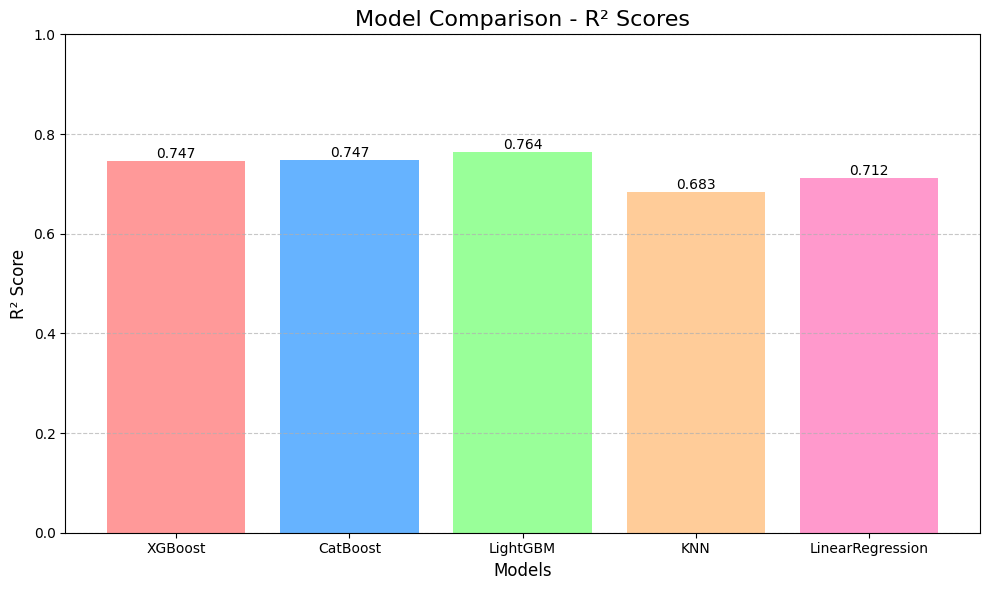

In [26]:
# R² scores for different models
r2_scores = {
    'XGBoost': r2_xgb,
    'CatBoost': r2_cat,
    'LightGBM': r2_lgb,
    'KNN': r2_knn,
    'LinearRegression': r2_lr 
}

# Models and their corresponding scores
models = list(r2_scores.keys())
scores = list(r2_scores.values())

# Create a color palette with 7 colors
colors = ['#FF9999', '#66B3FF', '#99FF99', '#FFCC99', '#FF99CC', '#99CCFF', '#CC99FF']

# Create the bar chart
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(models, scores, color=colors[:len(models)])  # Limit colors to the number of models

# Add titles and labels for the chart
ax.set_title('Model Comparison - R² Scores', fontsize=16)
ax.set_xlabel('Models', fontsize=12)
ax.set_ylabel('R² Score', fontsize=12)

# Set the y-axis limits between 0 and 1
ax.set_ylim(0, 1)

# Annotate each bar with its R² score
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.3f}',  # Display the score rounded to 3 decimal places
            ha='center', va='bottom')

# Add grid lines to the y-axis for better readability
ax.grid(True, axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()

#### Scatter Plot of Actual vs Predicted Values for the LightGBM Model

This code generates a scatter plot to compare the actual `y_test` values with the predicted values (`y_pred_lgb`)
from the LightGBM model. It also fits and plots a linear regression line to show the general trend of the predictions.


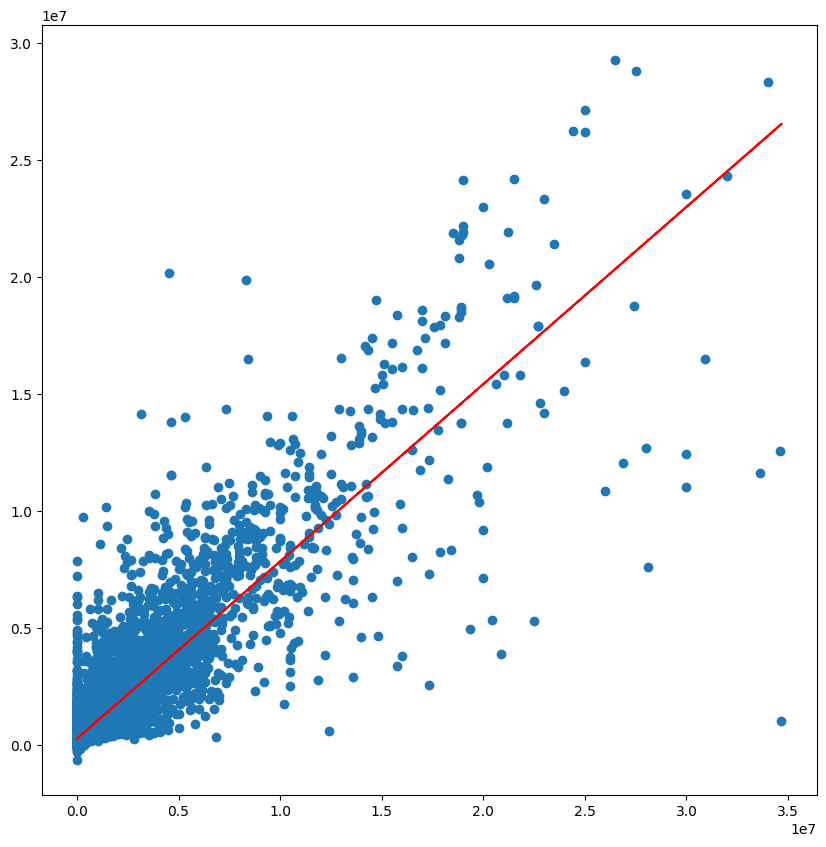

In [27]:
# Create a figure with specified dimensions (10x10)
fig = plt.figure(figsize=(10, 10))

# SCreate a scatter plot of the actual vs predicted values
plt.scatter(x=y_test, y=y_pred_lgb)

# Fit a line to the data (actual vs predicted) using a linear regression (polyfit)
m, b = np.polyfit(y_test, y_pred_lgb, 1)  # m is the slope, b is the intercept

# Plot the fitted line on top of the scatter plot
plt.plot(y_test, m*y_test + b, color='red')  # The red line represents the fitted linear trend

# Display the plot
plt.show()

#### Residual Calculation

- This code calculates the residuals (errors) for three models: XGBoost, CatBoost, and LightGBM.
- It then visualizes these residuals using a scatter plot to compare the performance of the models.


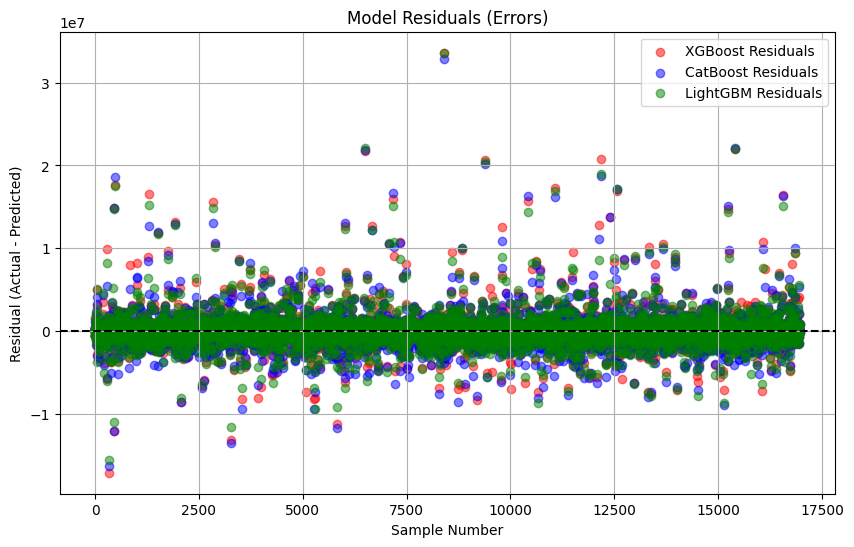

In [28]:
# Calculate the residuals for each model
residuals_xgboost = y_test - y_pred_xgboost  # Residuals for XGBoost
residuals_catboost = y_test - y_pred_cat      # Residuals for CatBoost
residuals_lightgbm = y_test - y_pred_lgb      # Residuals for LightGBM

# Create a scatter plot for each model's residuals
plt.figure(figsize=(10, 6))

# Plot XGBoost residuals
plt.scatter(range(len(y_test)), residuals_xgboost, label="XGBoost Residuals", color="red", alpha=0.5)

# Plot CatBoost residuals
plt.scatter(range(len(y_test)), residuals_catboost, label="CatBoost Residuals", color="blue", alpha=0.5)

# Plot LightGBM residuals
plt.scatter(range(len(y_test)), residuals_lightgbm, label="LightGBM Residuals", color="green", alpha=0.5)

# Add a horizontal line at 0 to represent no error
plt.axhline(0, color='black', linestyle='--')

# Add title and labels for clarity
plt.title("Model Residuals (Errors)")
plt.xlabel("Sample Number")
plt.ylabel("Residual (Actual - Predicted)")

# Add a legend to identify the models
plt.legend()

# Enable grid for better readability
plt.grid(True)

# Display the plot
plt.show()

#### Feature Importance Visualization

- This code creates a DataFrame containing the feature importance values from the CatBoost model.
- It then visualizes the feature importance using a horizontal bar plot.

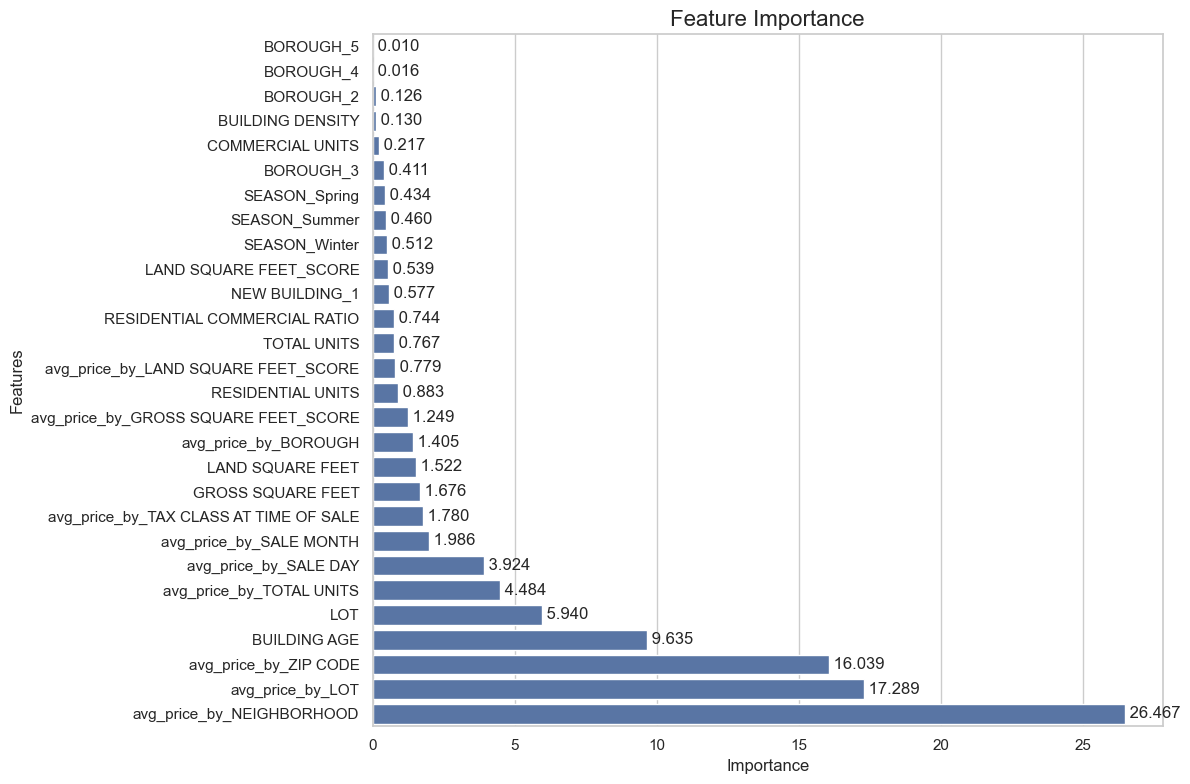

In [29]:
# Create a DataFrame with features and their importance scores
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': catboost_model.get_feature_importance()}).sort_values(by='Importance')

# Set the size and style of the plot
plt.figure(figsize=(12, 8))
sns.set(style="whitegrid")

# Create a horizontal bar plot for feature importance
ax = sns.barplot(x="Importance", y="Feature", data=feature_importance_df, orient="h")

# Set the title and axis labels
plt.title("Feature Importance", fontsize=16)
plt.xlabel("Importance", fontsize=12)
plt.ylabel("Features", fontsize=12)

# Add the importance values at the end of the bars
for i, v in enumerate(feature_importance_df["Importance"]):
    ax.text(v, i, f" {v:.3f}", va='center')  # Display the value at the end of each bar

# Display the plot with adjusted layout
plt.tight_layout()
plt.show()

### Shap Values

- **SHAP (Shapley Additive Explanations) values are a method used to explain the output of machine learning models.**
- They represent the contribution of each feature to the prediction for a particular instance (data point).
- SHAP values are based on cooperative game theory and allow us to interpret how much each feature has positively or negatively influenced the model's prediction.
- SHAP is particularly useful for complex models like XGBoost, LightGBM, and CatBoost, which are often seen as "black box" models due to their complexity.

#### SHAP Summary Plot
- The plot below uses shap.summary_plot to provide an overview of feature importance. shap.summary_plot(shap_values_lgb, X_test.head(500))
- This plot shows the global importance of each feature by summarizing the SHAP values for the first 500 instances in the test set.
- The color indicates whether the feature value was high (red) or low (blue), and the x-axis shows the impact of the feature on the model output.
- It is useful for understanding which features have the most influence on the model's predictions.

LightGBM SHAP summary plot:


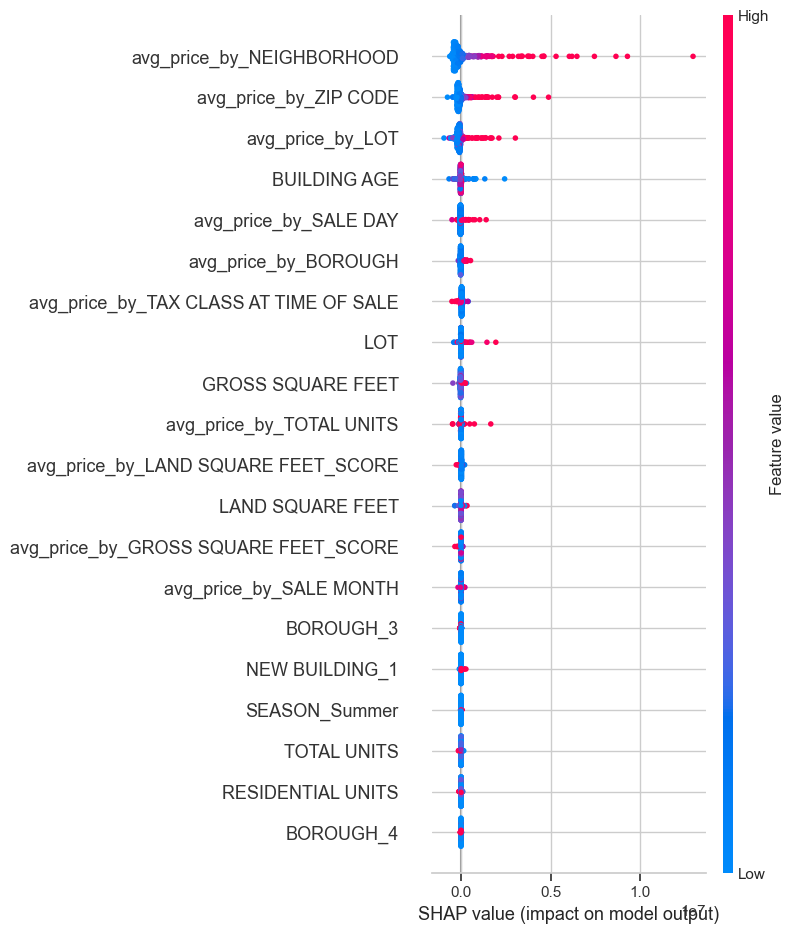

In [32]:
# LightGBM SHAP values
explainer_lgb = shap.Explainer(lgb_model)
shap_values_lgb = explainer_lgb(X_test.head(500))

print("LightGBM SHAP summary plot:")
shap.summary_plot(shap_values_lgb, X_test.head(500))

- `avg_price_by_NEIGHBORHOOD` has the largest effect on the predictions. High values (red) increase predictions, and low values (blue) decrease them.
- `avg_price_by_ZIP CODE` and `avg_price_by_LOT` are also significant contributors, with similar trends: high values increase predictions.
- Features such as `BUILDING AGE`, `avg_price_by_SALE DAY`, and `LOT` also show considerable importance but are slightly less impactful than the top three.
- Less influential features like `BOROUGH_4`, `RESIDENTIAL UNITS`, and `NEW BUILDING_1` show little to no impact on the model’s output, indicating they do not heavily influence the predictions.

#### SHAP Waterfall Plot:
- This plot explains the prediction for a specific instance (data point) by showing how each feature contributes to the model's final prediction.
- The model's base value (E[f(X)]) is shown at the bottom, which represents the average prediction of the model for the entire dataset.
- Each bar represents a feature's contribution (positive or negative) to the prediction for this particular instance.
- The features are ordered from most impactful to least impactful, with the ones at the top contributing the most to the prediction.

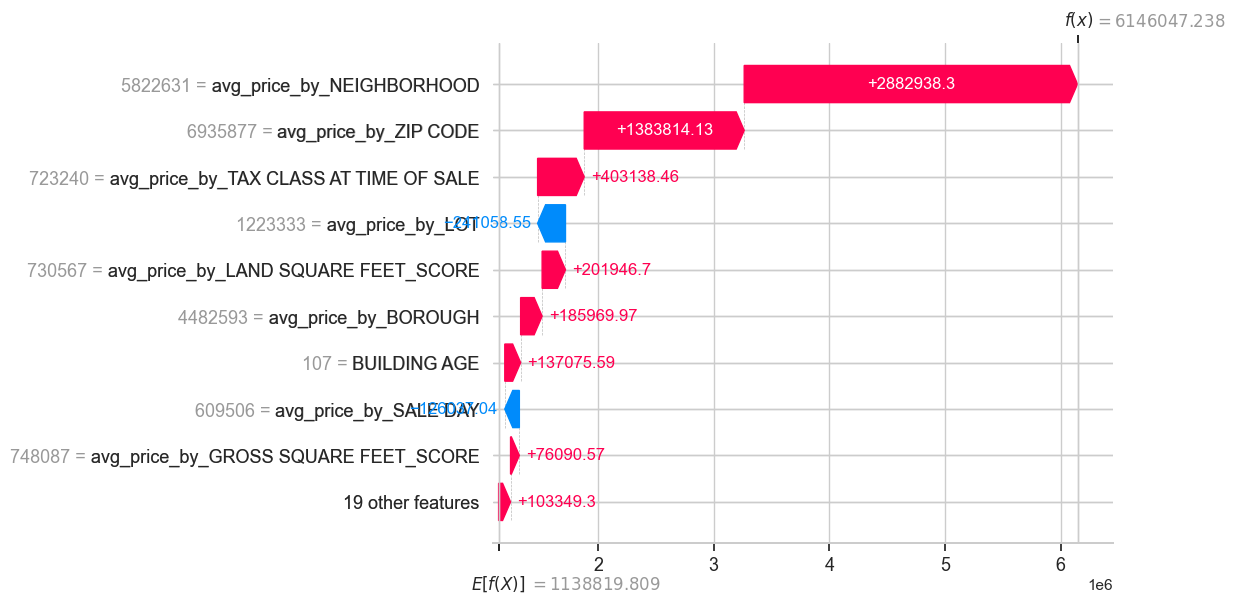

In [35]:
shap.waterfall_plot(shap_values_lgb[1])

- The base value (E[f(X)]) starts at 1,138,819.809, which is the average model prediction for all instances.
- For this specific instance, the final prediction (f(x)) is 6,146,047.238.
- `avg_price_by_NEIGHBORHOOD` has the largest positive contribution, adding +2,882,938.3 to the prediction.
- `avg_price_by_ZIP CODE` adds another +1,383,814.13 to the prediction, also making a significant positive contribution.
- On the negative side, `avg_price_by_LOT` reduces the prediction by -1,058.55.
- Other features, such as `avg_price_by_TAX CLASS AT TIME OF SALE` and `BUILDING AGE`, also contribute positively, while a few like `avg_price_by_SALE DAY` slightly reduce the prediction.

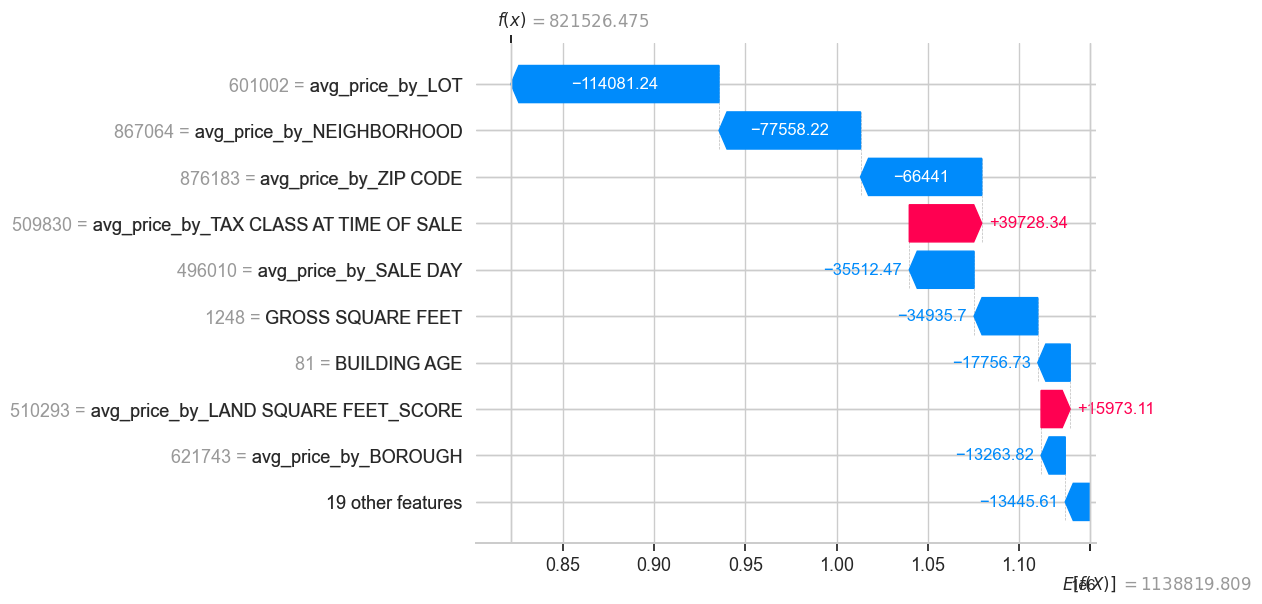

In [36]:
shap.waterfall_plot(shap_values_lgb[0])

- The base value (E[f(X)]) is 1,138,819.809, representing the average model prediction.
- The final predicted value (f(x)) for this instance is 821,526.475, which is lower than the base value due to the negative contributions from several features.
- `avg_price_by_LOT` has the largest negative impact, reducing the prediction by -114,081.24.
- `avg_price_by_NEIGHBORHOOD` and `avg_price_by_ZIP CODE` also contribute significantly negatively, with reductions of -77,558.22 and -66,441, respectively.
- `avg_price_by_TAX CLASS AT TIME OF SALE` adds a positive contribution of +39,728.34, slightly increasing the prediction.
- Similarly, `avg_price_by_LAND SQUARE FEET_SCORE` and `avg_price_by_BOROUGH` provide minor positive adjustments of +15,973.11 and +12,263.82, respectively.
- Most other features, such as `avg_price_by_SALE DAY` and `GROSS SQUARE FEET`, contribute negatively to the final prediction.